<a href="https://colab.research.google.com/github/KingLeo2000/Cinnamon_AI_Bootcamp2020/blob/master/NN_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My work:

- Implement a simple neural network (with one hidden layer) from scratch which is similar to the Keras's dense layer

- Experiment with different hyperparameter (number of hidden units, epochs, learning rate, momentumn factors)

## Preparation

In [0]:
#@title
from keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV ,ParameterGrid
import pandas as pd
np.random.seed(42)

In [2]:
# Load data and flatten them
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_data = np.concatenate([X_train, X_test], axis=0)/255
y_data = np.concatenate([y_train, y_test], axis=0)
X_data = X_data.reshape(X_data.shape[0],784)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train_full = X_data[:X_train.shape[0],:]
X_test = X_data[X_train.shape[0]:,:]
y_train_full = y_data[:y_train.shape[0]]
y_test = y_data[y_train.shape[0]:]

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [0]:
def sigmoid(z):
    s = 1/ (1 + np.exp(-z))
    return s

def cross_entropy(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum
    return L

## The first neural network is similar to the case of Keras

In [0]:
class simple_NN1:
    
    def __init__(self, hidden_state):
        self.n_h = hidden_state  
    
    def reshapeX(self, X_data):
        X = X_data.T
        return X

    def reshapeY(self, y_data):
        y = np.zeros((y_data.size, y_data.max()+1))
        y[np.arange(y_data.size), y_data] = 1
        y = y.T
        return y

    def initial_param(self,X_train, y_train):

        n_x = X_train.shape[0]
        n_class = y_train.shape[0]

        self.W1 = np.random.randn(self.n_h, n_x) * np.sqrt(1 / n_x)
        self.b1 = np.zeros((self.n_h, 1)) * np.sqrt(1 / n_x)
        self.W2 = np.random.randn(n_class, self.n_h) * np.sqrt(1 / self.n_h)
        self.b2 = np.zeros((n_class, 1))  * np.sqrt(1 / self.n_h)
        
    def forward(self, X_data):
        
        Z1 = np.matmul(self.W1, X_data) + self.b1
        A1 = sigmoid(Z1)
        Z2 = np.matmul(self.W2, A1) + self.b2
        A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)
        return [Z1, A1, Z2, A2]
    def backward(self):
        
        dZ2 = self.A2 - self.y_train
        dW2_ = (1/self.m) * np.matmul(dZ2, (self.A1).T)
        db2_ = (1/self.m) * np.sum(dZ2, axis=1, keepdims=True)
        dA1 = np.matmul((self.W2).T, dZ2)
        dZ1 = dA1 * sigmoid(self.Z1) * (1 - sigmoid(self.Z1))
        dW1_ = (1/self.m) * np.matmul(dZ1, (self.X_train).T)
        db1_ = (1/self.m) * np.sum(dZ1, axis=1, keepdims=True)
        
        if self.batch > 0:
            self.dW2 = (self.beta * self.dW2 + (1. - self.beta) * dW2_)
            self.db2 = (self.beta * self.db2 + (1. - self.beta) * db2_)
            self.dW1 = (self.beta * self.dW1 + (1. - self.beta) * dW1_)
            self.db1 = (self.beta * self.db1 + (1. - self.beta) * db1_)
        else:
            self.dW2 = dW2_
            self.db2 = db2_
            self.dW1 = dW1_
            self.db1 = db1_
        
        self.W2 = self.W2 - self.lr * self.dW2
        self.b2 = self.b2 - self.lr * self.db2
        self.W1 = self.W1 - self.lr * self.dW1
        self.b1 = self.b1 - self.lr * self.db1
    
    
    def fit(self, X_train, y_train, X_valid, y_valid, n_epochs, batch_size=32, learning_rate=3, beta=0.9):
        X_train = self.reshapeX(X_train)
        y_train = self.reshapeY(y_train)
        X_valid = self.reshapeX(X_valid)
        y_valid = self.reshapeY(y_valid)
        
        self.lr = learning_rate
        self.beta = beta
        self.initial_param(X_train, y_train)
        print(f'Training on {X_train.shape[1]} samples validate on {X_valid.shape[1]} samples'.upper())
        self.train_loss= []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []

        for epoch in range(n_epochs):

            shuffle = np.random.permutation(X_train.shape[1])
            X_shuffled = X_train[:, shuffle]
            y_shuffled = y_train[:, shuffle]
            n_batches = X_train.shape[1] // batch_size
            for batch in tqdm(range(n_batches), desc=f'Epoch {epoch+1}/{n_epochs} : '):
                begin = batch * batch_size
                end = min(begin + batch_size, X_shuffled.shape[1] - 1)
                self.X_train = X_shuffled[:, begin:end]
                self.y_train = y_shuffled[:, begin:end]
                self.m = (self.X_train).shape[1]

                self.batch = batch
                self.Z1, self.A1, self.Z2, self.A2 = self.forward(self.X_train)
                self.backward()
            train_ouput = self.forward(X_train)[-1]
            train_predict = np.argmax(train_ouput, axis=0)
            train_loss = cross_entropy(y_train, train_ouput)
            train_acc = accuracy_score(train_predict, np.argmax(y_train, axis=0))
 
            val_output = self.forward(X_valid)[-1]
            val_predict = np.argmax(val_output, axis=0)
            val_loss = cross_entropy(y_valid, val_output)           
            val_acc = accuracy_score(val_predict, np.argmax(y_valid, axis=0))

            print(f'Train loss: {train_loss:.4f}. Train accuracy: {train_acc:.4f}')
            print(f'Valid loss: {val_loss:.4f}. Valid_accuracy: {val_acc:.4f}')
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
    def history(self):
        fig, ax = plt.subplots(1,2, figsize=(16, 6))
        plt.subplot(1,2,1)
        plt.plot(self.train_loss, label='Train')
        plt.plot(self.val_loss, label='Validataion')
        plt.title('Loss on training and validation sets')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc="upper right")
        plt.subplot(1,2,2)
        plt.plot(self.train_acc, label='Train')
        plt.plot(self.val_acc, label='Validataion')
        plt.title('Accuracy on training and validation sets')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc="upper left")                
        fig.suptitle('nah', fontsize=20)
        plt.show()

    def predict_proba(self, X_test):
        X_test = self.reshapeX(X_test)
        return self.forward(X_test)[-1]
    
    def predict(self, X_test):
        proba = self.predict_proba(X_test)
        predictions = np.argmax(proba, axis=0)
        return predictions
    
    def score(self, X_test, y_test, ):
        predictions = self.predict(X_test)
        print('Accuracy : ', accuracy_score(predictions, y_test))

In [15]:
model = simple_NN1(64)
model.fit(X_train, y_train,X_valid, y_valid, 20, batch_size=64, learning_rate=0.2)

TRAINING ON 48000 SAMPLES VALIDATE ON 12000 SAMPLES


Epoch 1/20 : 100%|██████████| 750/750 [00:01<00:00, 464.83it/s]


Train loss: 0.3540. Train accuracy: 0.9037
Valid loss: 0.3513. Valid_accuracy: 0.9043


Epoch 2/20 : 100%|██████████| 750/750 [00:01<00:00, 472.93it/s]


Train loss: 0.2861. Train accuracy: 0.9179
Valid loss: 0.2858. Valid_accuracy: 0.9195


Epoch 3/20 : 100%|██████████| 750/750 [00:01<00:00, 454.94it/s]


Train loss: 0.2486. Train accuracy: 0.9290
Valid loss: 0.2530. Valid_accuracy: 0.9291


Epoch 4/20 : 100%|██████████| 750/750 [00:01<00:00, 469.71it/s]


Train loss: 0.2230. Train accuracy: 0.9367
Valid loss: 0.2290. Valid_accuracy: 0.9353


Epoch 5/20 : 100%|██████████| 750/750 [00:01<00:00, 480.65it/s]


Train loss: 0.2052. Train accuracy: 0.9417
Valid loss: 0.2133. Valid_accuracy: 0.9399


Epoch 6/20 : 100%|██████████| 750/750 [00:01<00:00, 510.37it/s]


Train loss: 0.1899. Train accuracy: 0.9451
Valid loss: 0.1993. Valid_accuracy: 0.9430


Epoch 7/20 : 100%|██████████| 750/750 [00:01<00:00, 512.33it/s]


Train loss: 0.1737. Train accuracy: 0.9495
Valid loss: 0.1850. Valid_accuracy: 0.9480


Epoch 8/20 : 100%|██████████| 750/750 [00:01<00:00, 511.32it/s]


Train loss: 0.1633. Train accuracy: 0.9535
Valid loss: 0.1771. Valid_accuracy: 0.9504


Epoch 9/20 : 100%|██████████| 750/750 [00:01<00:00, 524.08it/s]


Train loss: 0.1551. Train accuracy: 0.9556
Valid loss: 0.1693. Valid_accuracy: 0.9516


Epoch 10/20 : 100%|██████████| 750/750 [00:01<00:00, 512.22it/s]


Train loss: 0.1430. Train accuracy: 0.9598
Valid loss: 0.1591. Valid_accuracy: 0.9564


Epoch 11/20 : 100%|██████████| 750/750 [00:01<00:00, 525.53it/s]


Train loss: 0.1335. Train accuracy: 0.9625
Valid loss: 0.1512. Valid_accuracy: 0.9576


Epoch 12/20 : 100%|██████████| 750/750 [00:01<00:00, 512.20it/s]


Train loss: 0.1290. Train accuracy: 0.9634
Valid loss: 0.1483. Valid_accuracy: 0.9573


Epoch 13/20 : 100%|██████████| 750/750 [00:01<00:00, 524.54it/s]


Train loss: 0.1214. Train accuracy: 0.9660
Valid loss: 0.1425. Valid_accuracy: 0.9594


Epoch 14/20 : 100%|██████████| 750/750 [00:01<00:00, 496.33it/s]


Train loss: 0.1137. Train accuracy: 0.9687
Valid loss: 0.1365. Valid_accuracy: 0.9597


Epoch 15/20 : 100%|██████████| 750/750 [00:01<00:00, 536.11it/s]


Train loss: 0.1096. Train accuracy: 0.9696
Valid loss: 0.1326. Valid_accuracy: 0.9606


Epoch 16/20 : 100%|██████████| 750/750 [00:01<00:00, 498.98it/s]


Train loss: 0.1033. Train accuracy: 0.9716
Valid loss: 0.1282. Valid_accuracy: 0.9618


Epoch 17/20 : 100%|██████████| 750/750 [00:01<00:00, 483.71it/s]


Train loss: 0.0986. Train accuracy: 0.9732
Valid loss: 0.1256. Valid_accuracy: 0.9623


Epoch 18/20 : 100%|██████████| 750/750 [00:01<00:00, 493.23it/s]


Train loss: 0.0946. Train accuracy: 0.9742
Valid loss: 0.1226. Valid_accuracy: 0.9634


Epoch 19/20 : 100%|██████████| 750/750 [00:01<00:00, 481.16it/s]


Train loss: 0.0910. Train accuracy: 0.9751
Valid loss: 0.1202. Valid_accuracy: 0.9641


Epoch 20/20 : 100%|██████████| 750/750 [00:01<00:00, 496.54it/s]


Train loss: 0.0877. Train accuracy: 0.9764
Valid loss: 0.1174. Valid_accuracy: 0.9664


### Plot loss and accuracy curves

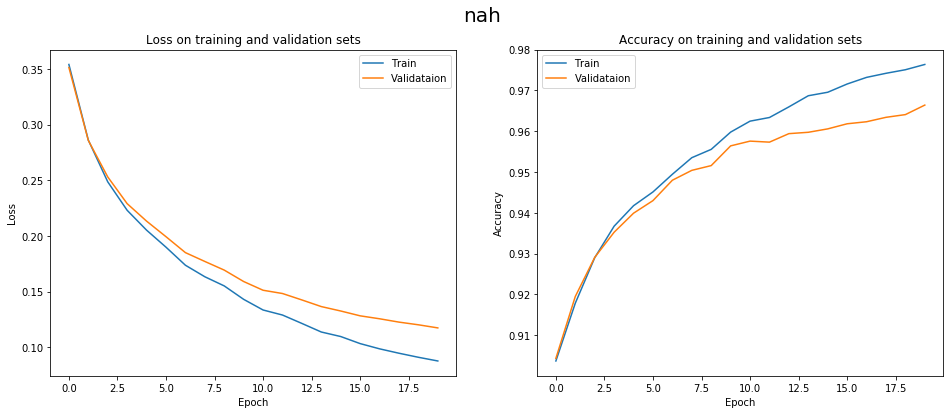

In [16]:
model.history()

### Score on test set

In [17]:
model.score(X_test, y_test)

Accuracy :  0.9664


### Confusion matrix

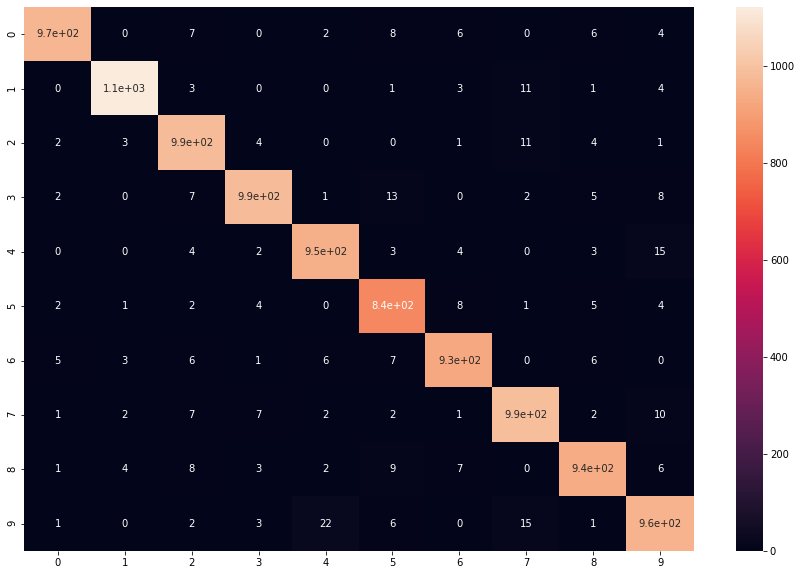

In [20]:
plt.figure(figsize=(15,10))
df = pd.DataFrame(confusion_matrix(model.predict(X_test), y_test), index=list(range(10)), columns=list(range(10)))
sns.heatmap(df, annot=True, )

### Retrain our model with unscaled data 
 Just flatten the Mnist data

In [0]:
X_train_raw = X_train_full*255
X_test_raw = X_test*255
X_train, X_valid, y_train, y_valid = train_test_split(X_train_raw, y_train_full, test_size=0.2)

In [22]:
model = simple_NN1(64)
model.fit(X_train, y_train,X_valid, y_valid, 20, batch_size=64, learning_rate=0.2)

TRAINING ON 48000 SAMPLES VALIDATE ON 12000 SAMPLES


Epoch 1/20 :   0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
Epoch 1/20 : 100%|██████████| 750/750 [00:01<00:00, 464.16it/s]


Train loss: 1.1779. Train accuracy: 0.5862
Valid loss: 1.1851. Valid_accuracy: 0.5824


Epoch 2/20 : 100%|██████████| 750/750 [00:01<00:00, 404.18it/s]


Train loss: 1.0391. Train accuracy: 0.6578
Valid loss: 1.0411. Valid_accuracy: 0.6555


Epoch 3/20 : 100%|██████████| 750/750 [00:01<00:00, 469.66it/s]


Train loss: 0.9137. Train accuracy: 0.7057
Valid loss: 0.9175. Valid_accuracy: 0.7019


Epoch 4/20 : 100%|██████████| 750/750 [00:01<00:00, 472.55it/s]


Train loss: 1.0394. Train accuracy: 0.6294
Valid loss: 1.0406. Valid_accuracy: 0.6278


Epoch 5/20 : 100%|██████████| 750/750 [00:01<00:00, 475.83it/s]


Train loss: 1.0125. Train accuracy: 0.6545
Valid loss: 1.0011. Valid_accuracy: 0.6619


Epoch 6/20 : 100%|██████████| 750/750 [00:01<00:00, 483.81it/s]


Train loss: 1.0982. Train accuracy: 0.5906
Valid loss: 1.0948. Valid_accuracy: 0.5934


Epoch 7/20 : 100%|██████████| 750/750 [00:01<00:00, 441.69it/s]


Train loss: 0.9936. Train accuracy: 0.6600
Valid loss: 0.9886. Valid_accuracy: 0.6587


Epoch 8/20 : 100%|██████████| 750/750 [00:01<00:00, 474.52it/s]


Train loss: 0.9425. Train accuracy: 0.6853
Valid loss: 0.9406. Valid_accuracy: 0.6888


Epoch 9/20 : 100%|██████████| 750/750 [00:01<00:00, 469.24it/s]


Train loss: 0.8619. Train accuracy: 0.7268
Valid loss: 0.8583. Valid_accuracy: 0.7228


Epoch 10/20 : 100%|██████████| 750/750 [00:01<00:00, 464.73it/s]


Train loss: 0.9048. Train accuracy: 0.6863
Valid loss: 0.9094. Valid_accuracy: 0.6854


Epoch 11/20 : 100%|██████████| 750/750 [00:01<00:00, 428.30it/s]


Train loss: 0.9731. Train accuracy: 0.6484
Valid loss: 0.9702. Valid_accuracy: 0.6498


Epoch 12/20 : 100%|██████████| 750/750 [00:01<00:00, 455.70it/s]


Train loss: 0.9455. Train accuracy: 0.6808
Valid loss: 0.9348. Valid_accuracy: 0.6838


Epoch 13/20 : 100%|██████████| 750/750 [00:01<00:00, 467.25it/s]


Train loss: 0.9345. Train accuracy: 0.6851
Valid loss: 0.9184. Valid_accuracy: 0.6890


Epoch 14/20 : 100%|██████████| 750/750 [00:01<00:00, 468.94it/s]


Train loss: 0.9046. Train accuracy: 0.6981
Valid loss: 0.8964. Valid_accuracy: 0.7036


Epoch 15/20 : 100%|██████████| 750/750 [00:01<00:00, 461.29it/s]


Train loss: 0.8333. Train accuracy: 0.7187
Valid loss: 0.8367. Valid_accuracy: 0.7137


Epoch 16/20 : 100%|██████████| 750/750 [00:01<00:00, 458.64it/s]


Train loss: 0.8279. Train accuracy: 0.7313
Valid loss: 0.8418. Valid_accuracy: 0.7314


Epoch 17/20 : 100%|██████████| 750/750 [00:01<00:00, 471.09it/s]


Train loss: 0.8145. Train accuracy: 0.7135
Valid loss: 0.8048. Valid_accuracy: 0.7172


Epoch 18/20 : 100%|██████████| 750/750 [00:01<00:00, 476.78it/s]


Train loss: 0.7374. Train accuracy: 0.7576
Valid loss: 0.7416. Valid_accuracy: 0.7586


Epoch 19/20 : 100%|██████████| 750/750 [00:01<00:00, 463.68it/s]


Train loss: 0.8351. Train accuracy: 0.7148
Valid loss: 0.8297. Valid_accuracy: 0.7172


Epoch 20/20 : 100%|██████████| 750/750 [00:01<00:00, 464.09it/s]


Train loss: 0.7696. Train accuracy: 0.7482
Valid loss: 0.7659. Valid_accuracy: 0.7520


In [23]:
model.score(X_test_raw, y_test)

Accuracy :  0.7539


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


## The second neural network 
- Built under BaseEstimator in order to interact with scikit-learn model selection tools (Grid search)
- Eliminate the tqdm for avoiding redundant logging messages


In [0]:

class simple_NN2(BaseEstimator, ClassifierMixin):
    def __init__(self, n_h=32, n_epochs=10, batch_size=32, lr=0.1, beta=0.9):
        self.n_h = n_h
        self.n_epochs = n_epochs
        self.batch_size = batch_size                 
        self.lr = lr
        self.beta = beta

    def _reshapeX(self, X_data):
        X = X_data.T
        return X

    def _reshapeY(self, y_data):
        y = np.zeros((y_data.size, y_data.max()+1))
        y[np.arange(y_data.size), y_data] = 1
        y = y.T
        return y

    def _initial_param(self,X_train, y_train):

        n_x = X_train.shape[0]
        n_class = y_train.shape[0]

        self.W1 = np.random.randn(self.n_h, n_x) * np.sqrt(1 / n_x)
        self.b1 = np.zeros((self.n_h, 1)) * np.sqrt(1 / n_x)
        self.W2 = np.random.randn(n_class, self.n_h) * np.sqrt(1 / self.n_h)
        self.b2 = np.zeros((n_class, 1))  * np.sqrt(1 / self.n_h)
        
    def _forward(self, X_data):
        
        Z1 = np.matmul(self.W1, X_data) + self.b1
        A1 = sigmoid(Z1)
        Z2 = np.matmul(self.W2, A1) + self.b2
        A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)
        return [Z1, A1, Z2, A2]
    def _backward(self):
        
        dZ2 = self.A2 - self.y_train
        dW2_ = (1/self.m) * np.matmul(dZ2, (self.A1).T)
        db2_ = (1/self.m) * np.sum(dZ2, axis=1, keepdims=True)
        dA1 = np.matmul((self.W2).T, dZ2)
        dZ1 = dA1 * sigmoid(self.Z1) * (1 - sigmoid(self.Z1))
        dW1_ = (1/self.m) * np.matmul(dZ1, (self.X_train).T)
        db1_ = (1/self.m) * np.sum(dZ1, axis=1, keepdims=True)
        
        if self.batch > 0:
            self.dW2 = (self.beta * self.dW2 + (1. - self.beta) * dW2_)
            self.db2 = (self.beta * self.db2 + (1. - self.beta) * db2_)
            self.dW1 = (self.beta * self.dW1 + (1. - self.beta) * dW1_)
            self.db1 = (self.beta * self.db1 + (1. - self.beta) * db1_)
        else:
            self.dW2 = dW2_
            self.db2 = db2_
            self.dW1 = dW1_
            self.db1 = db1_
        
        self.W2 = self.W2 - self.lr * self.dW2
        self.b2 = self.b2 - self.lr * self.db2
        self.W1 = self.W1 - self.lr * self.dW1
        self.b1 = self.b1 - self.lr * self.db1
    
    
    def fit(self, X_train, y_train, X_test=X_test, y_test=y_test):
        X_train = self._reshapeX(X_train)
        y_train = self._reshapeY(y_train)
        X_test = self._reshapeX(X_test)
        y_test = self._reshapeY(y_test)       
        self._initial_param(X_train, y_train)
        #print(f'Training on {X_train.shape[1]} samples test on {X_test.shape[1]} samples'.upper())
        self.train_loss= []
        self.train_acc = []
        self.test_loss = []
        self.test_acc = []

        for epoch in range(self.n_epochs):
            shuffle = np.random.permutation(X_train.shape[1])
            X_shuffled = X_train[:, shuffle]
            y_shuffled = y_train[:, shuffle]
            n_batches = X_train.shape[1] // self.batch_size

            for batch in range(n_batches):
                begin = batch * self.batch_size
                end = min(begin + self.batch_size, X_shuffled.shape[1] - 1)
                self.X_train = X_shuffled[:, begin:end]
                self.y_train = y_shuffled[:, begin:end]
                self.m = (self.X_train).shape[1]

                self.batch = batch
                self.Z1, self.A1, self.Z2, self.A2 = self._forward(self.X_train)
                self._backward()

            train_ouput = self._forward(X_train)[-1]
            train_predict = np.argmax(train_ouput, axis=0)
            train_loss = cross_entropy(y_train, train_ouput)
            train_acc = accuracy_score(train_predict, np.argmax(y_train, axis=0))
 
            test_output = self._forward(X_test)[-1]
            test_predict = np.argmax(test_output, axis=0)
            test_loss = cross_entropy(y_test, test_output)           
            test_acc = accuracy_score(test_predict, np.argmax(y_test, axis=0))

            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            self.test_loss.append(test_loss)
            self.test_acc.append(test_acc)
        self.history()
    
    def history(self):
        print(f'Train accuracy : {self.train_acc[-1]:.3f}. Test accuracy : {self.test_acc[-1]:.3f}')
        fig, ax = plt.subplots(1,2, figsize=(22, 6))
        plt.subplot(1,2,1)
        plt.plot(self.train_loss, label='Train')
        plt.plot(self.test_loss, label='Test')
        plt.title('Loss on training and test sets')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc="upper right")
        plt.subplot(1,2,2)
        plt.plot(self.train_acc, label='Test')
        plt.plot(self.test_acc, label='Test')
        plt.title('Accuracy on training and test sets')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc="upper left") 
        plt.suptitle(f'Hidden state: {self.n_h}. Epochs: {self.n_epochs}. Learning rate: {self.lr}. Momentum: {self.beta}')               
        plt.show()

    def predict_proba(self, X_test):
        X_test = self._reshapeX(X_test)
        return self._forward(X_test)[-1]
    
    def predict(self, X_test):
        proba = self.predict_proba(X_test)
        predictions = np.argmax(proba, axis=0)
        return predictions
    
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        return accuracy_score(predictions, y_test)

### Experiment with different hyperparameters

In [0]:
params_grid = {'n_h':[20, 50, 100],
               'n_epochs':[20, 50, 100],
               'lr':[0.1, 0.001],
               'beta': [0.9, 0.8, 0.1, 0.0]}

Train accuracy : 0.961. Test accuracy : 0.950


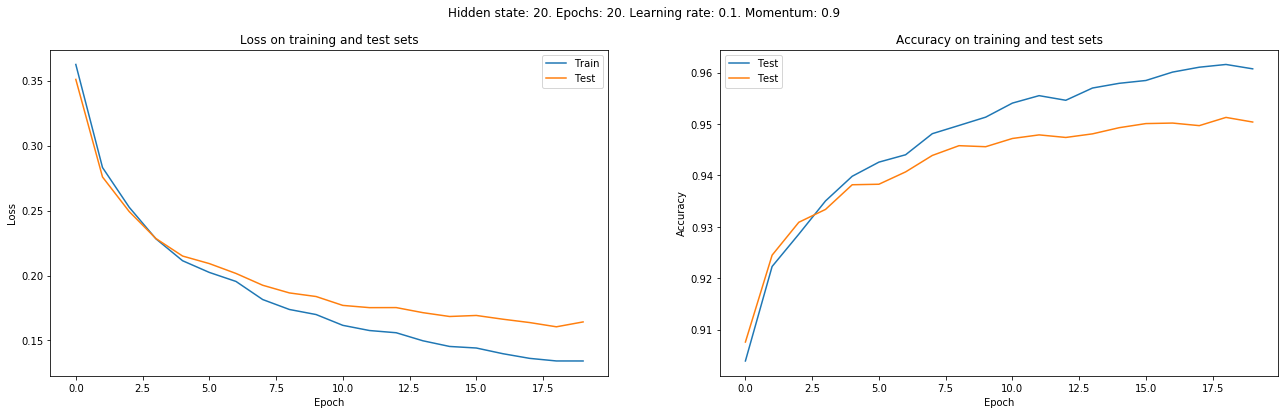

Train accuracy : 0.978. Test accuracy : 0.968


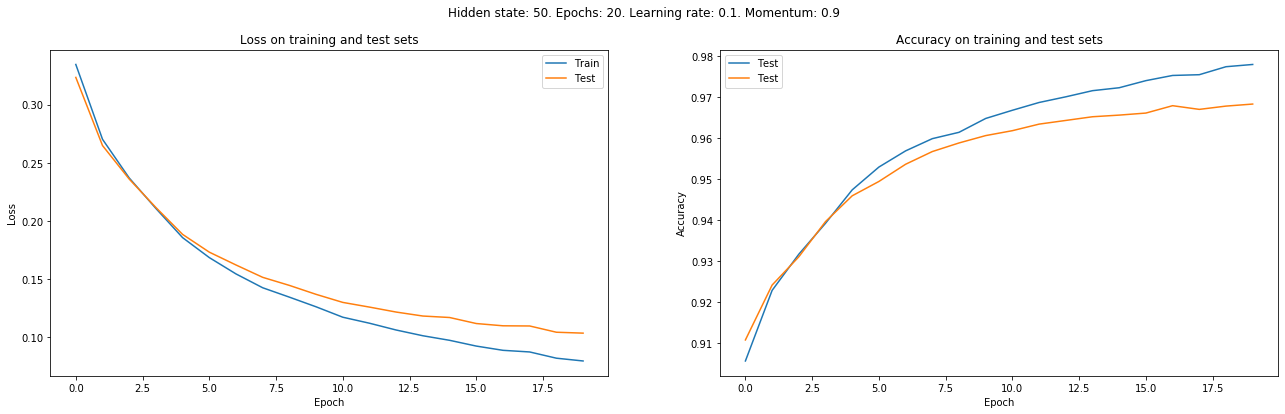

Train accuracy : 0.981. Test accuracy : 0.973


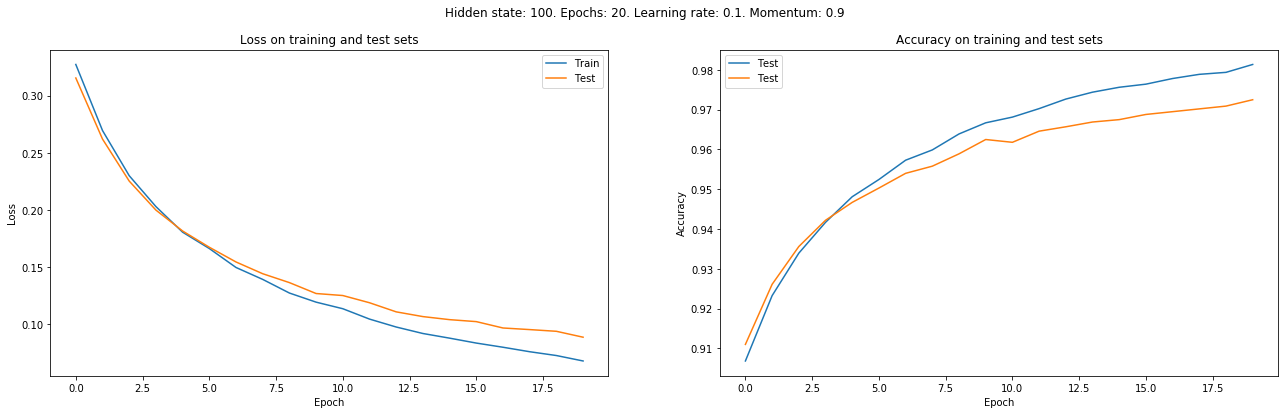

Train accuracy : 0.978. Test accuracy : 0.963


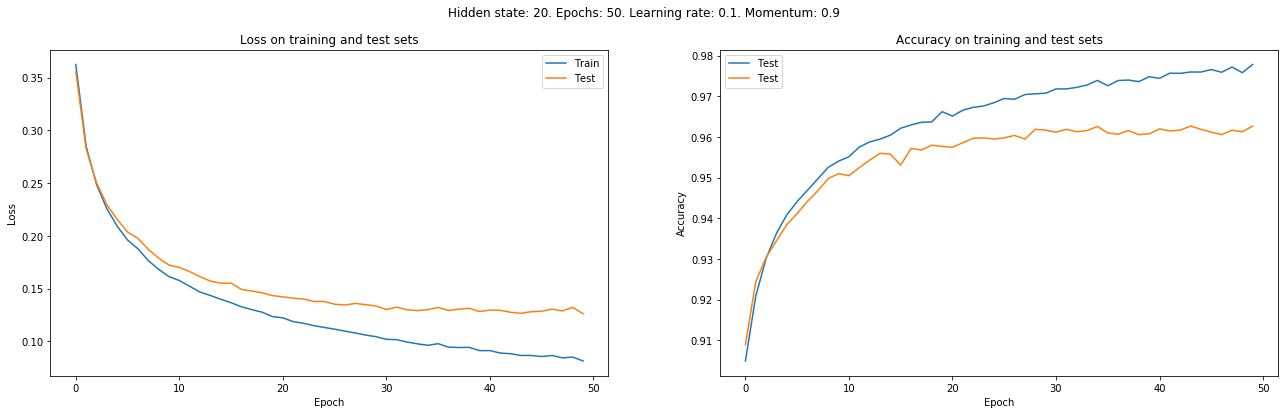

Train accuracy : 0.991. Test accuracy : 0.972


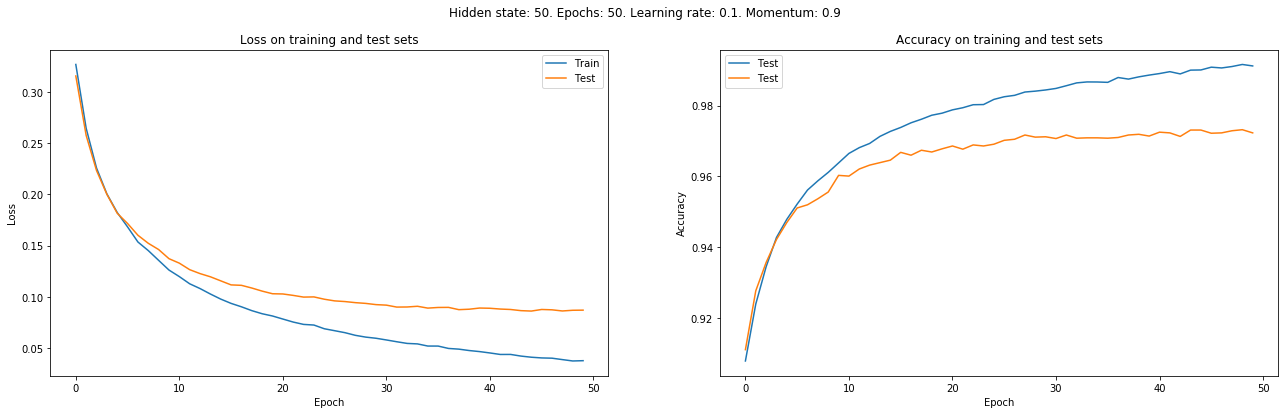

Train accuracy : 0.995. Test accuracy : 0.978


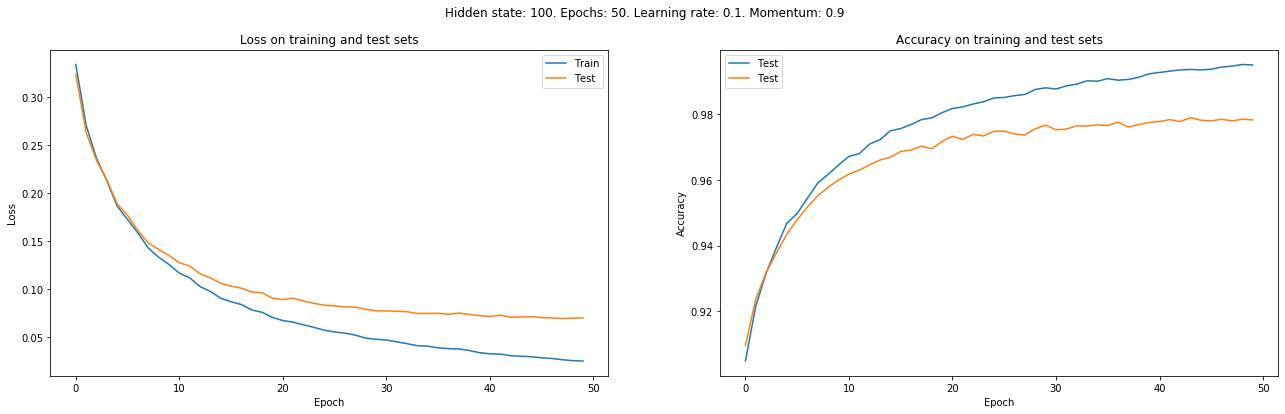

Train accuracy : 0.986. Test accuracy : 0.960


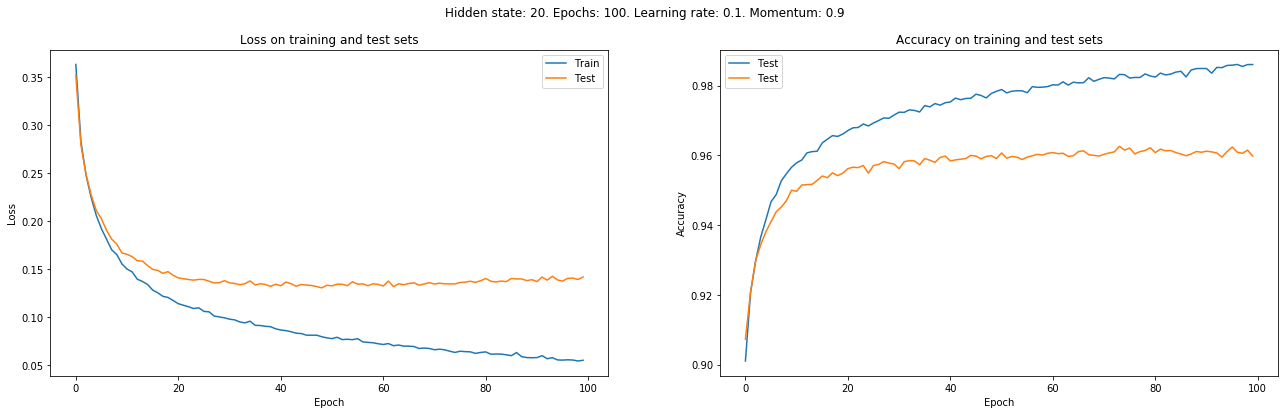

Train accuracy : 0.998. Test accuracy : 0.975


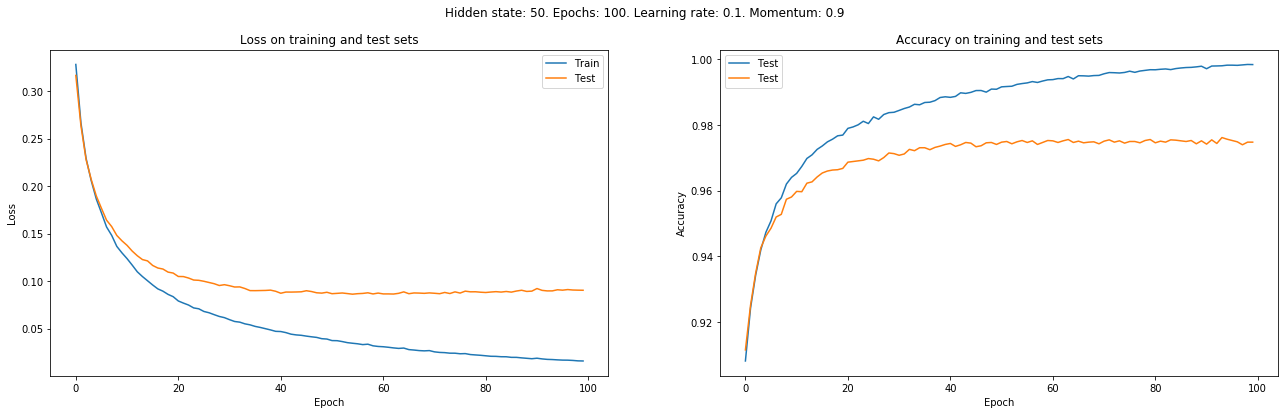

Train accuracy : 1.000. Test accuracy : 0.978


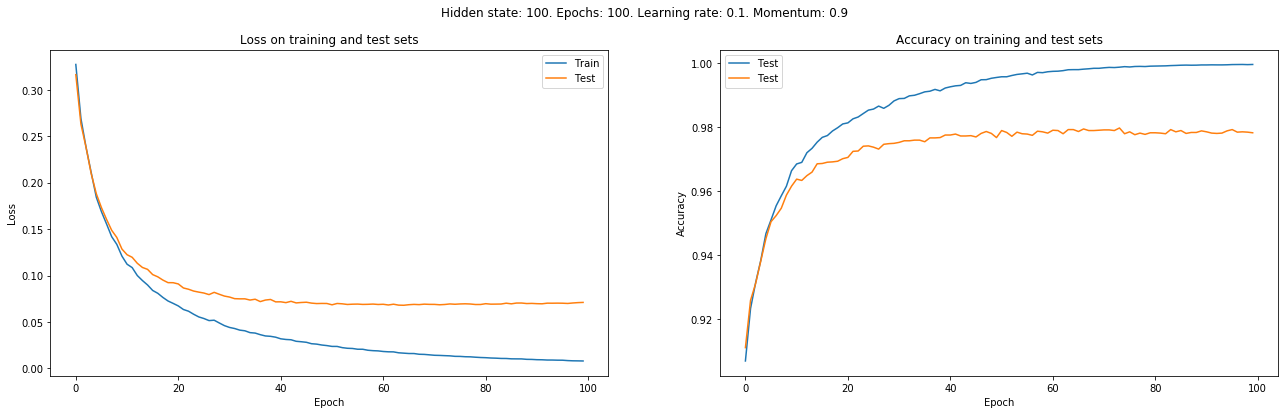

Train accuracy : 0.818. Test accuracy : 0.828


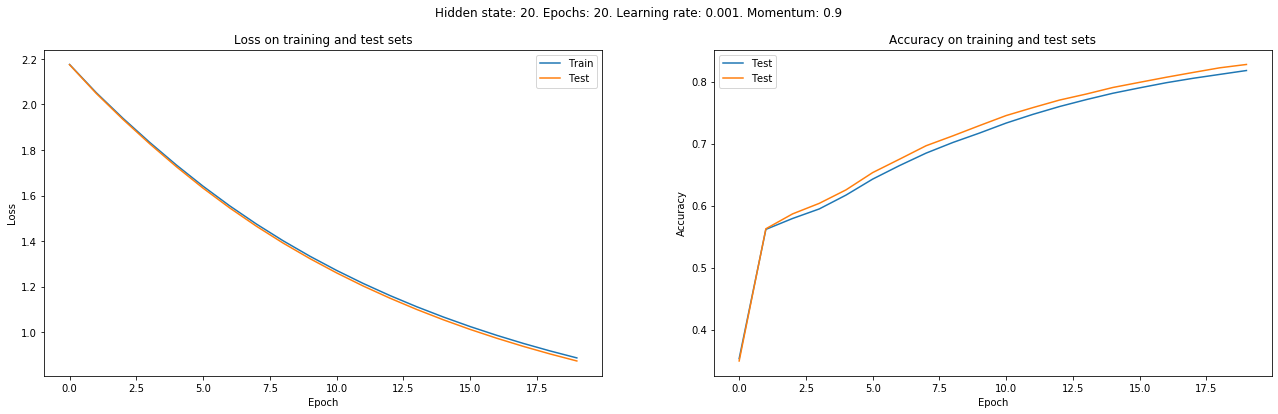

Train accuracy : 0.844. Test accuracy : 0.854


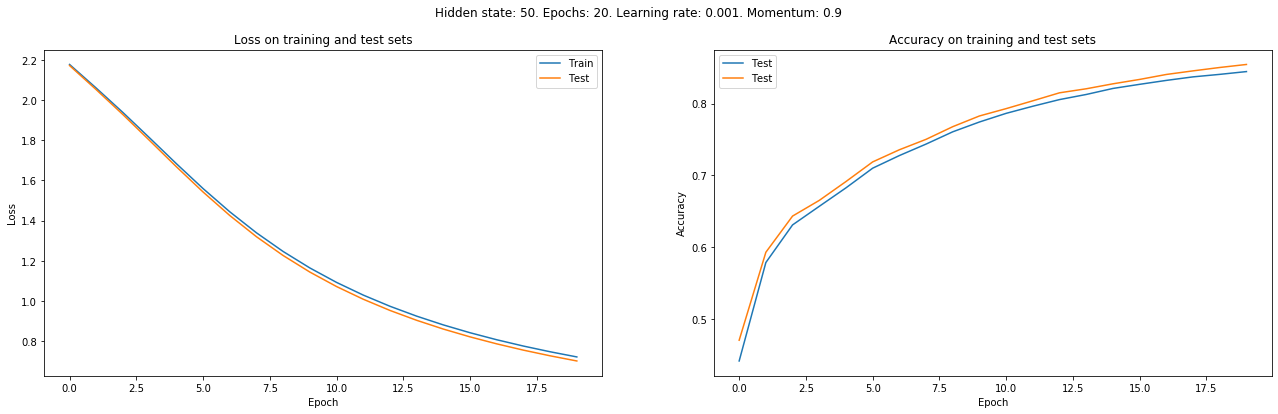

Train accuracy : 0.857. Test accuracy : 0.865


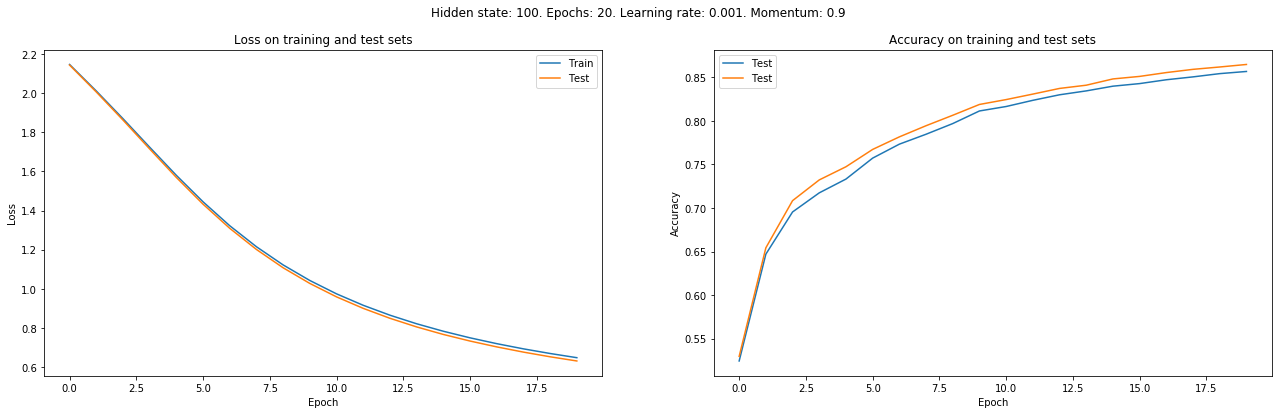

Train accuracy : 0.881. Test accuracy : 0.887


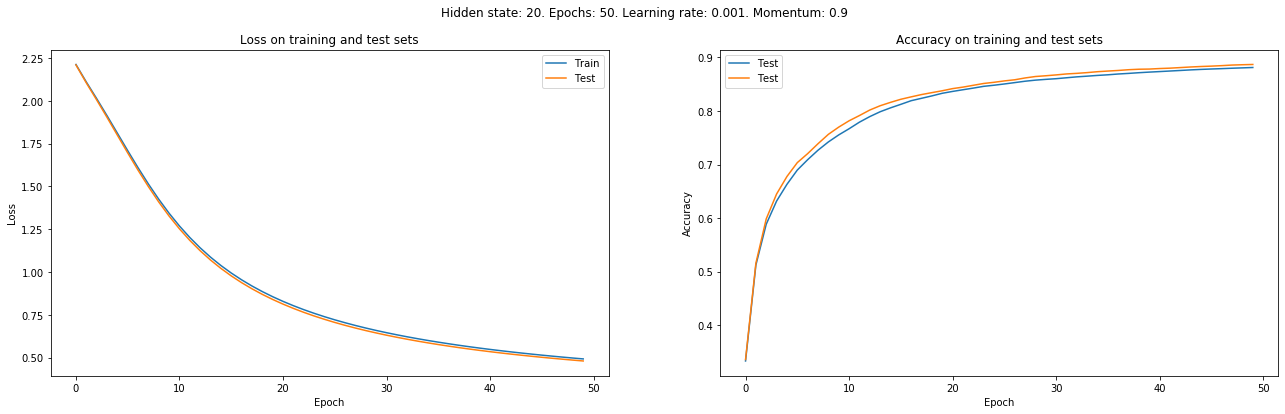

Train accuracy : 0.890. Test accuracy : 0.898


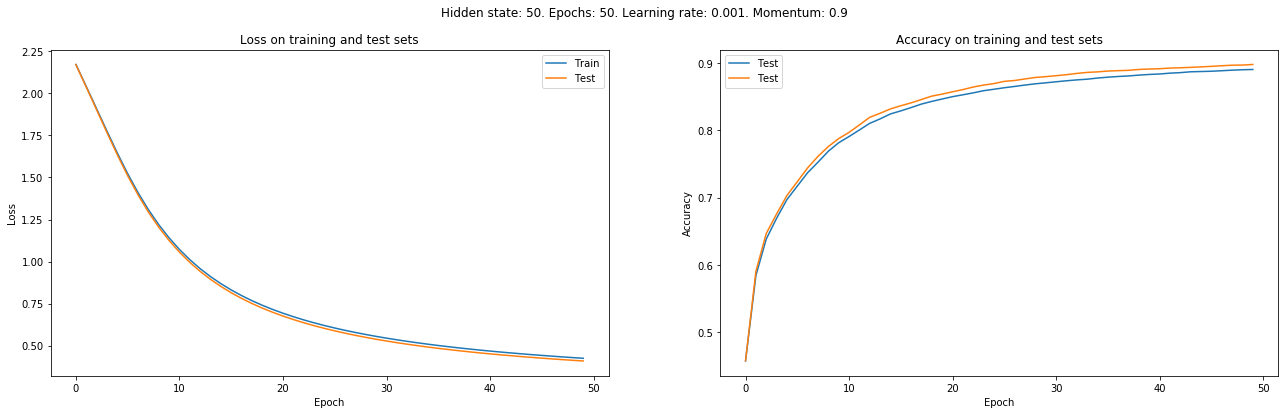

Train accuracy : 0.892. Test accuracy : 0.898


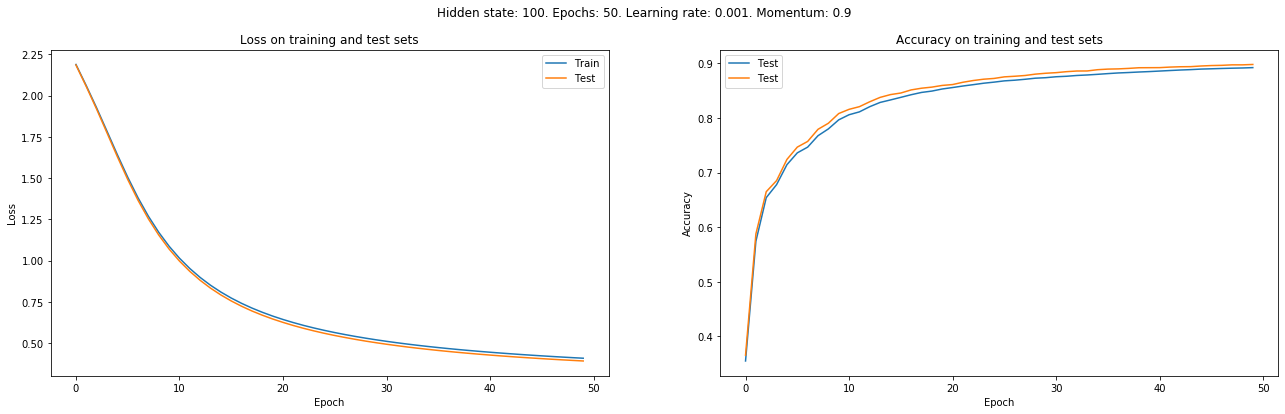

Train accuracy : 0.904. Test accuracy : 0.906


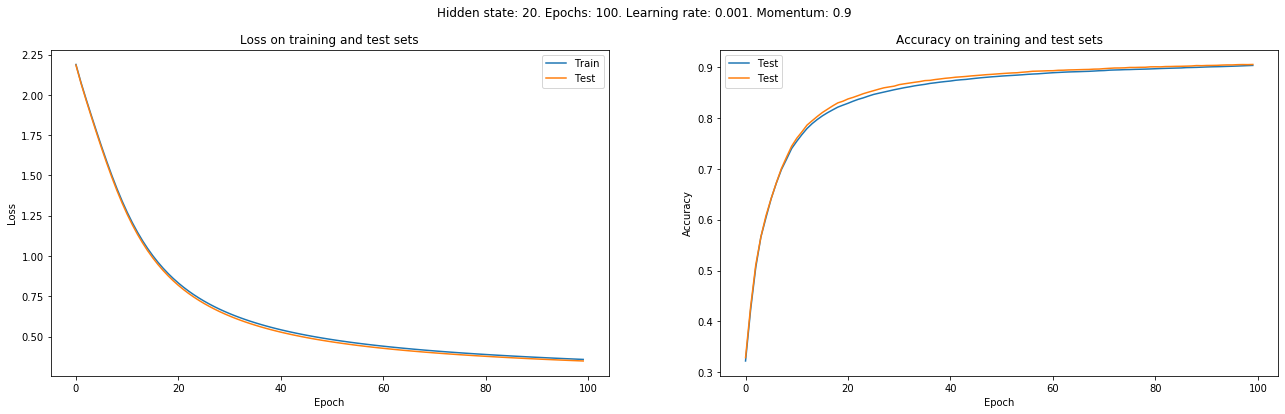

Train accuracy : 0.911. Test accuracy : 0.916


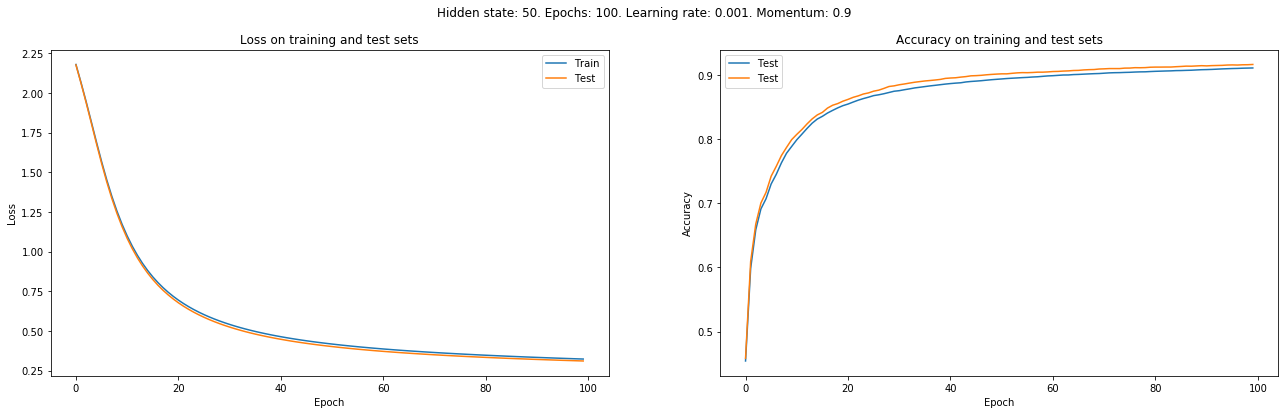

Train accuracy : 0.908. Test accuracy : 0.913


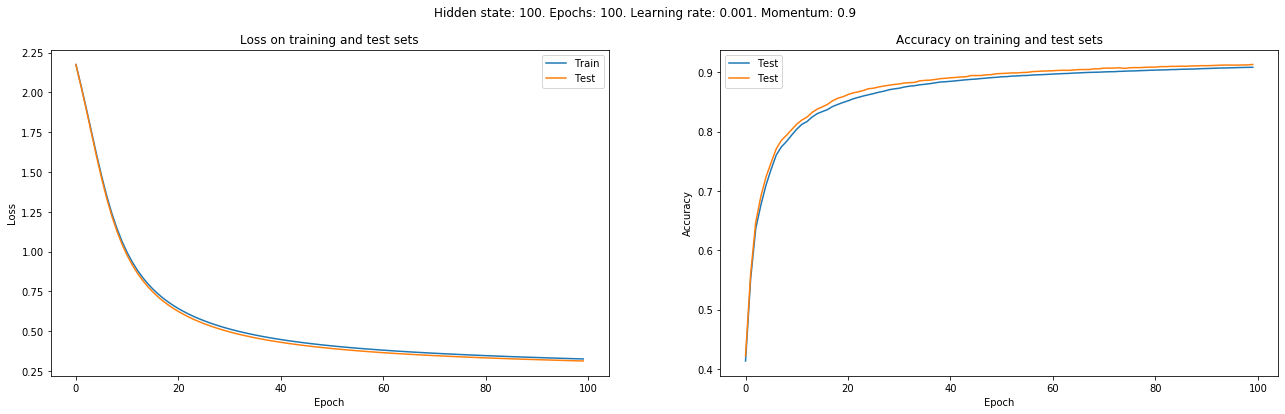

Train accuracy : 0.963. Test accuracy : 0.951


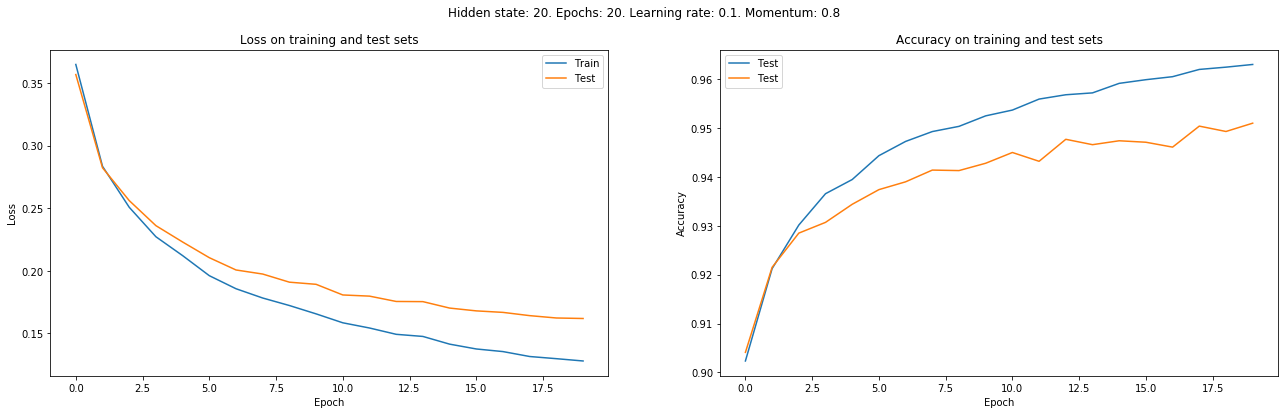

Train accuracy : 0.979. Test accuracy : 0.970


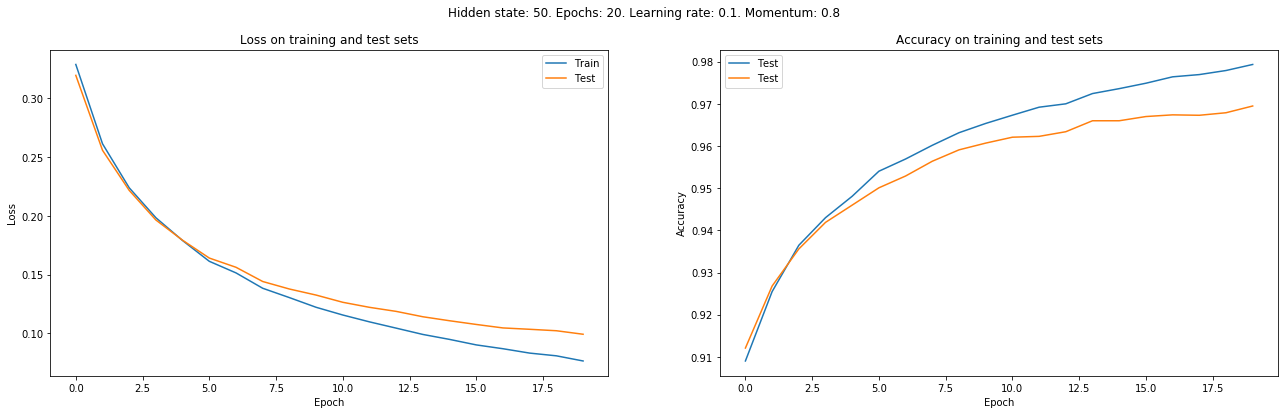

Train accuracy : 0.981. Test accuracy : 0.971


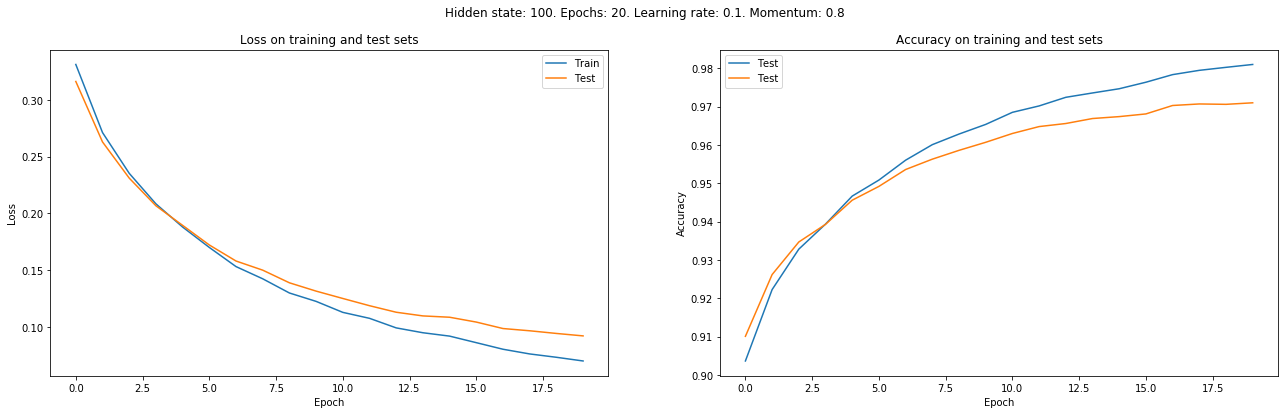

Train accuracy : 0.976. Test accuracy : 0.958


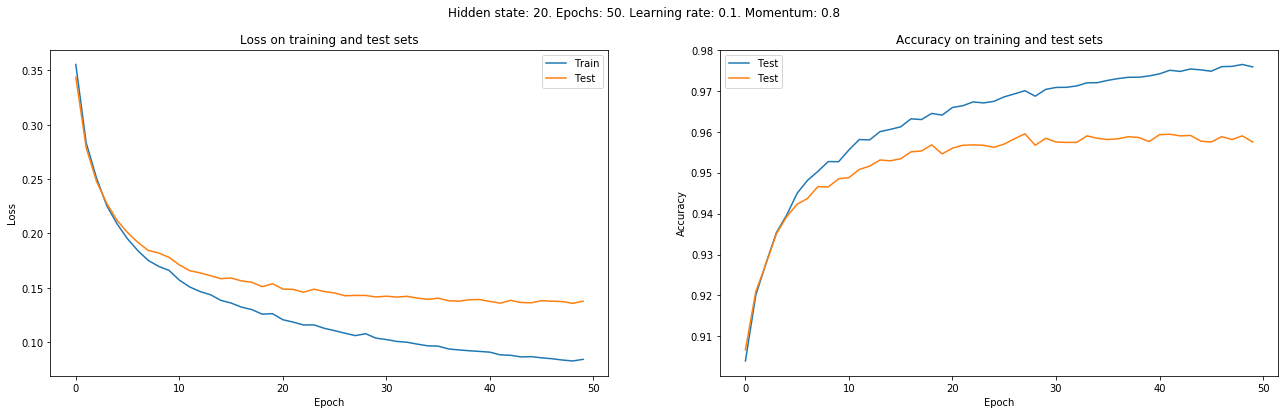

Train accuracy : 0.992. Test accuracy : 0.974


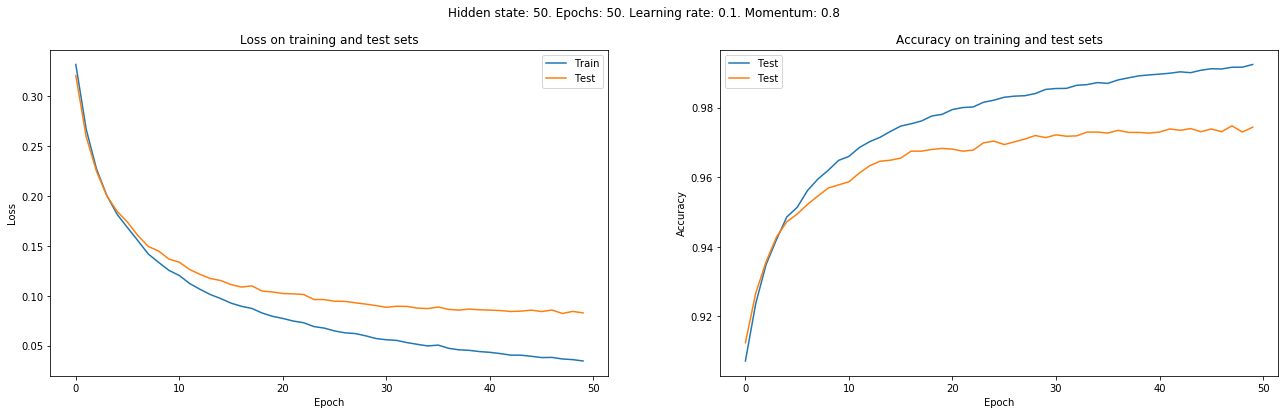

Train accuracy : 0.995. Test accuracy : 0.979


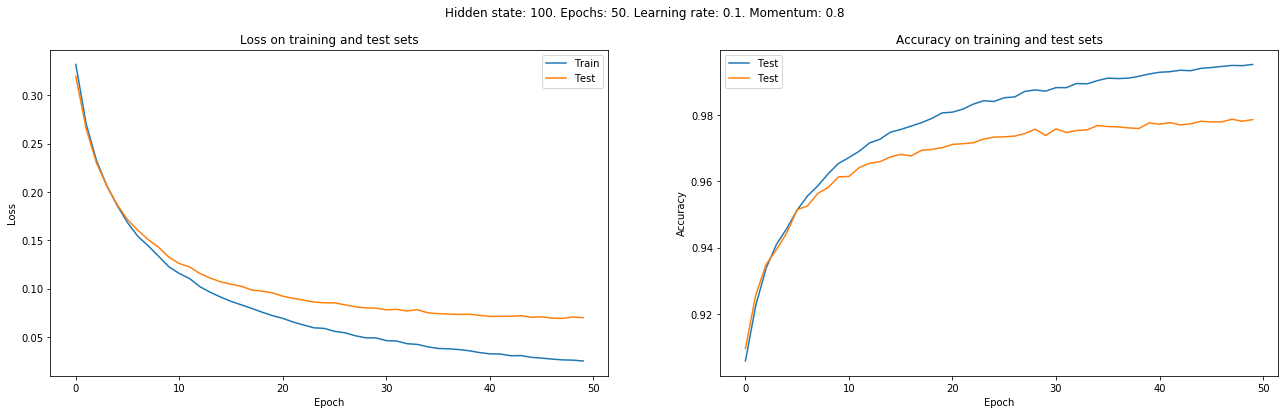

Train accuracy : 0.983. Test accuracy : 0.955


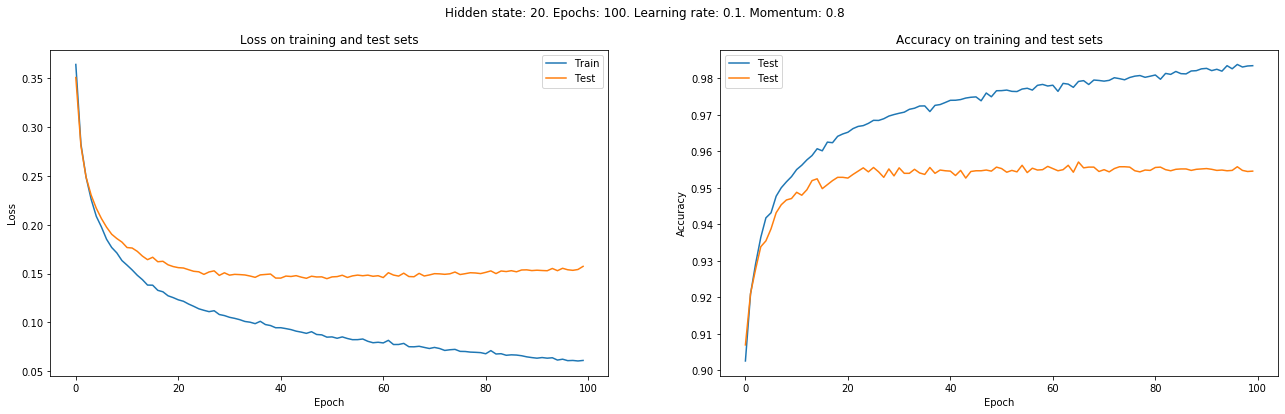

Train accuracy : 0.999. Test accuracy : 0.973


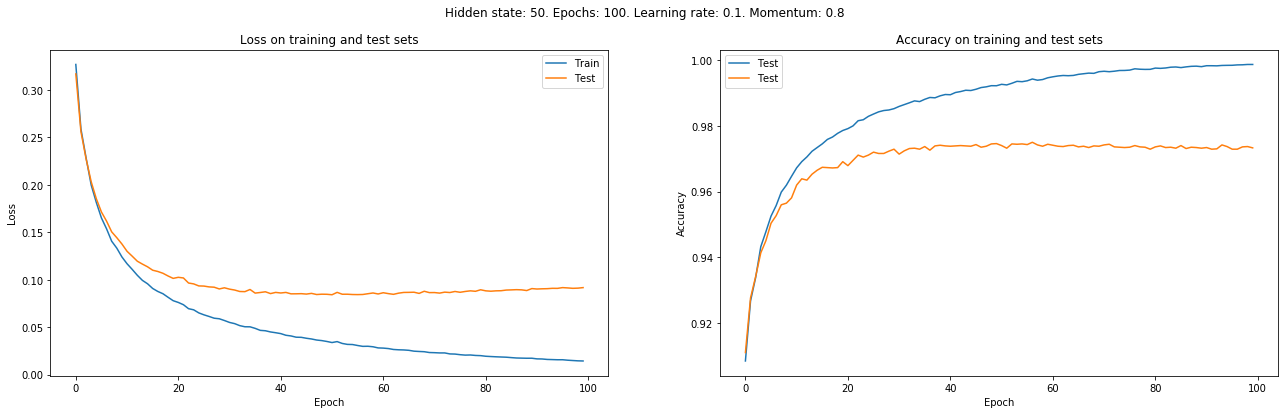

Train accuracy : 1.000. Test accuracy : 0.980


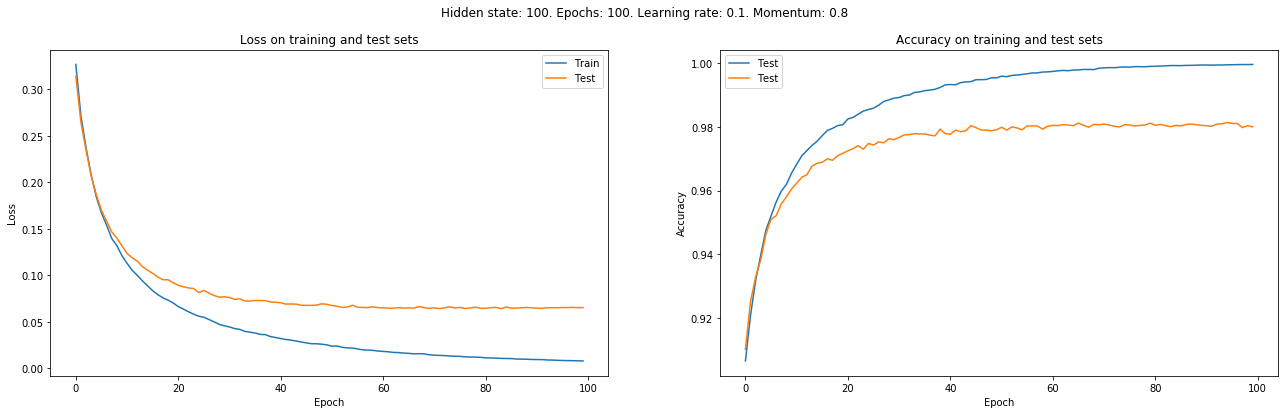

Train accuracy : 0.830. Test accuracy : 0.837


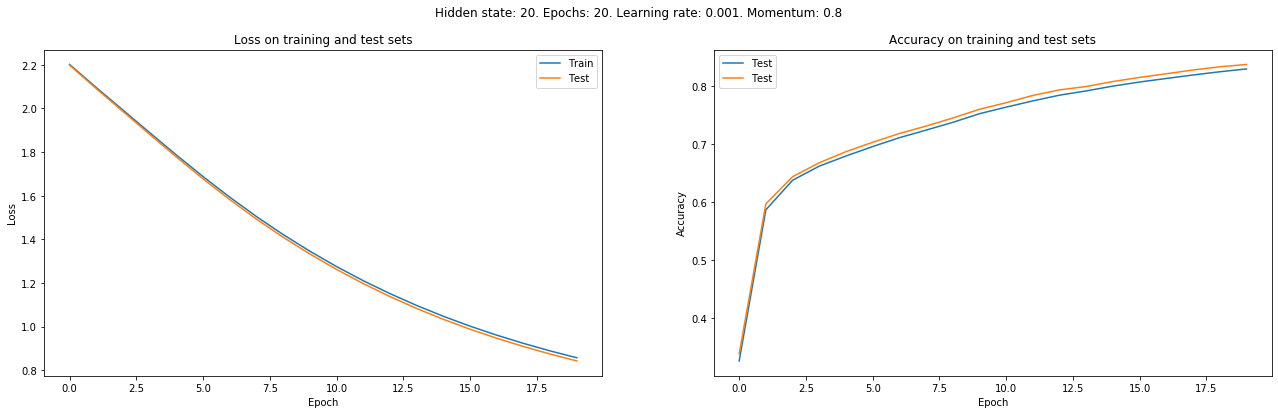

Train accuracy : 0.847. Test accuracy : 0.856


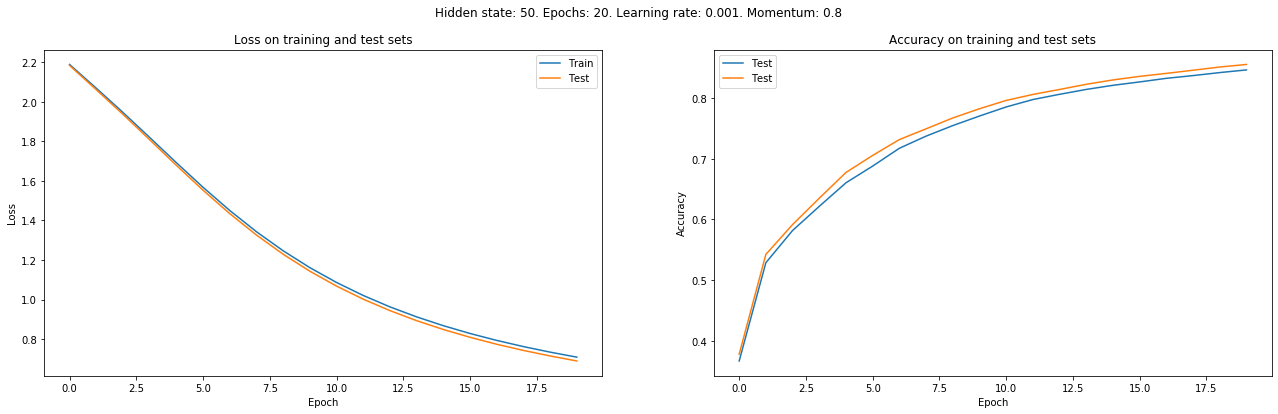

Train accuracy : 0.855. Test accuracy : 0.862


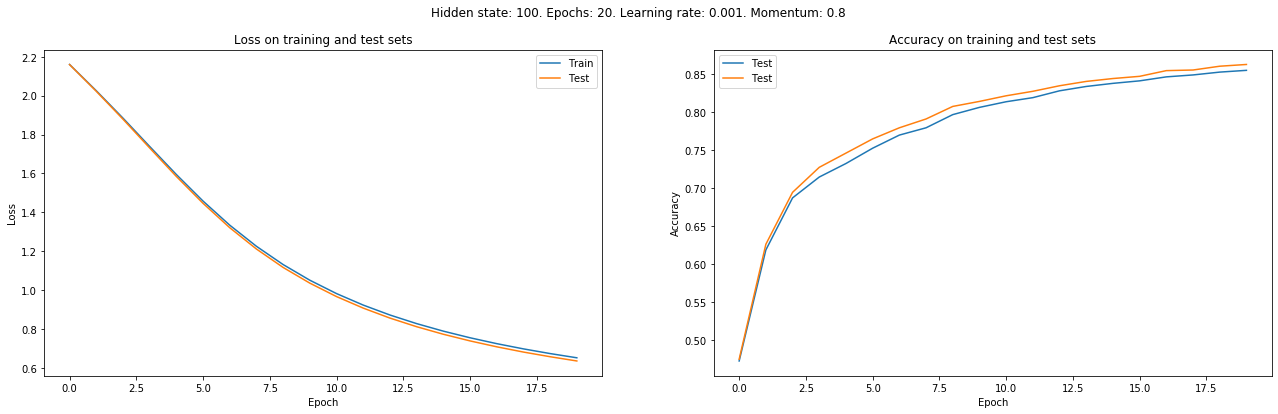

Train accuracy : 0.883. Test accuracy : 0.889


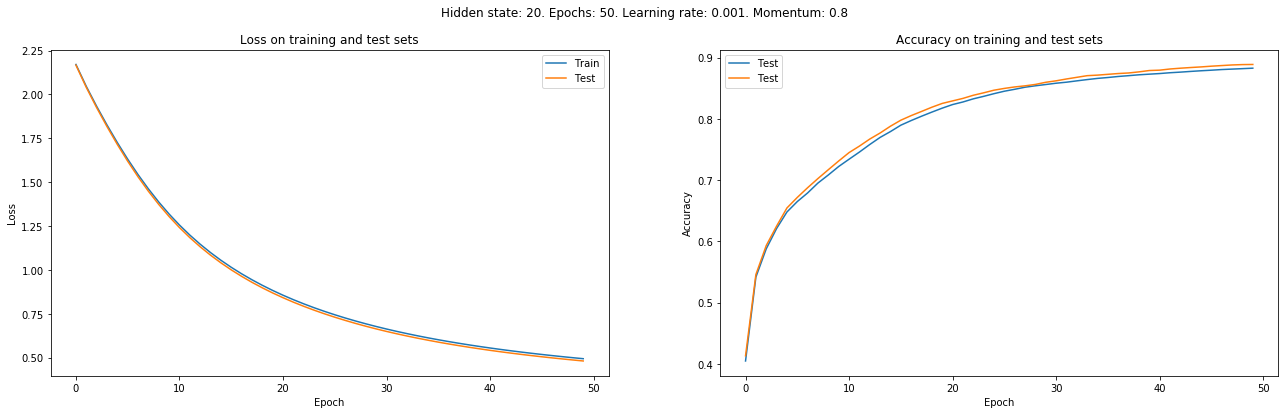

Train accuracy : 0.893. Test accuracy : 0.899


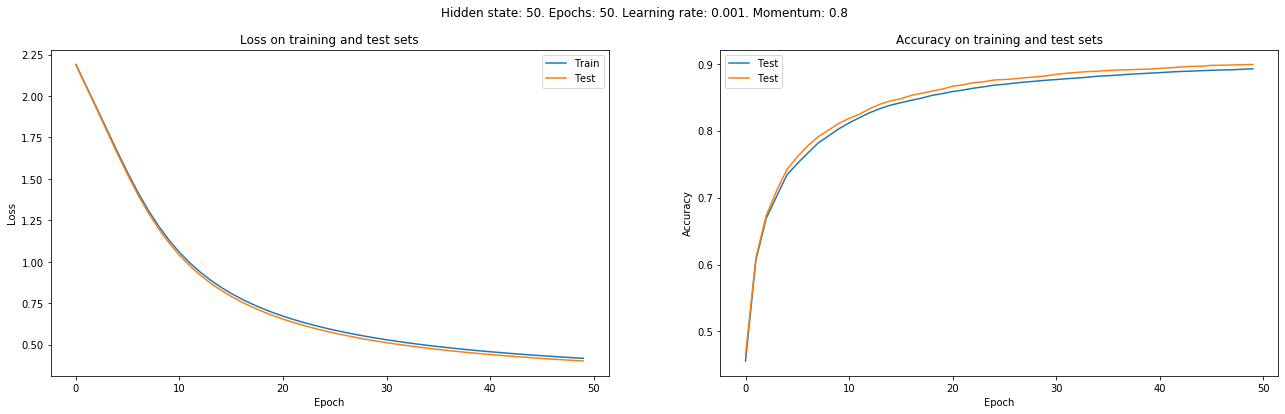

Train accuracy : 0.892. Test accuracy : 0.898


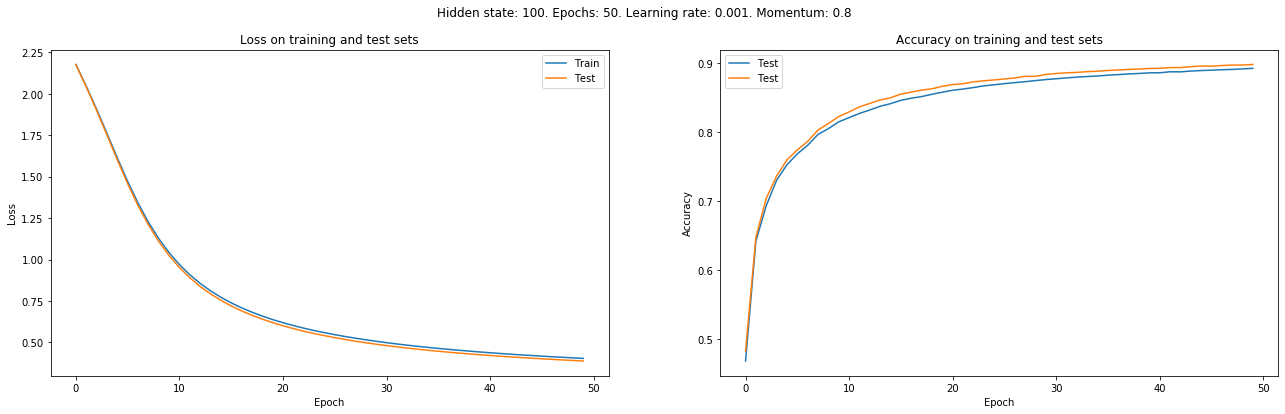

Train accuracy : 0.903. Test accuracy : 0.908


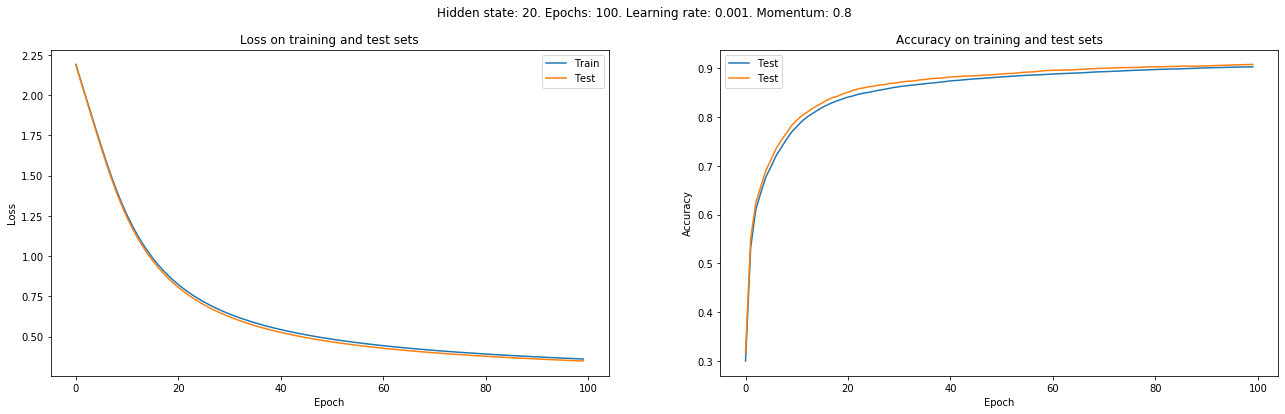

Train accuracy : 0.909. Test accuracy : 0.914


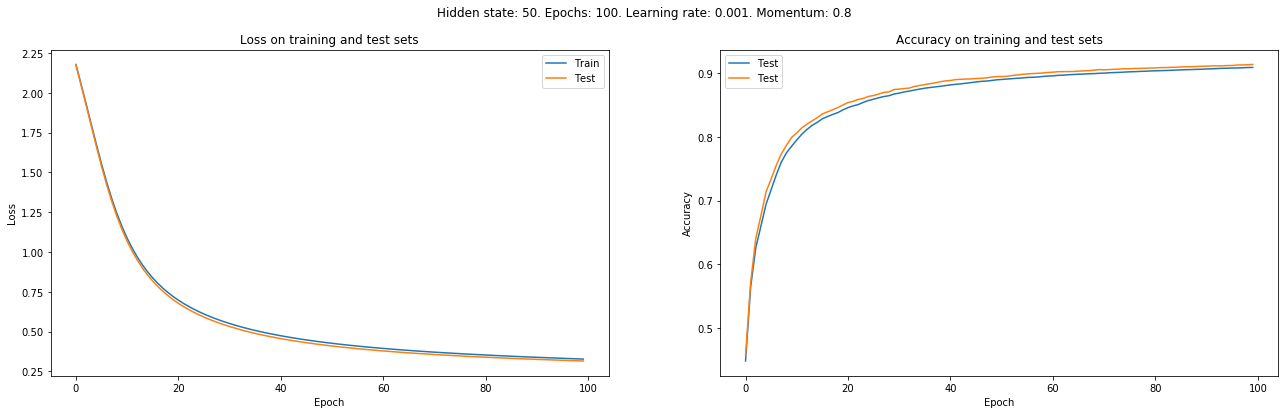

Train accuracy : 0.908. Test accuracy : 0.914


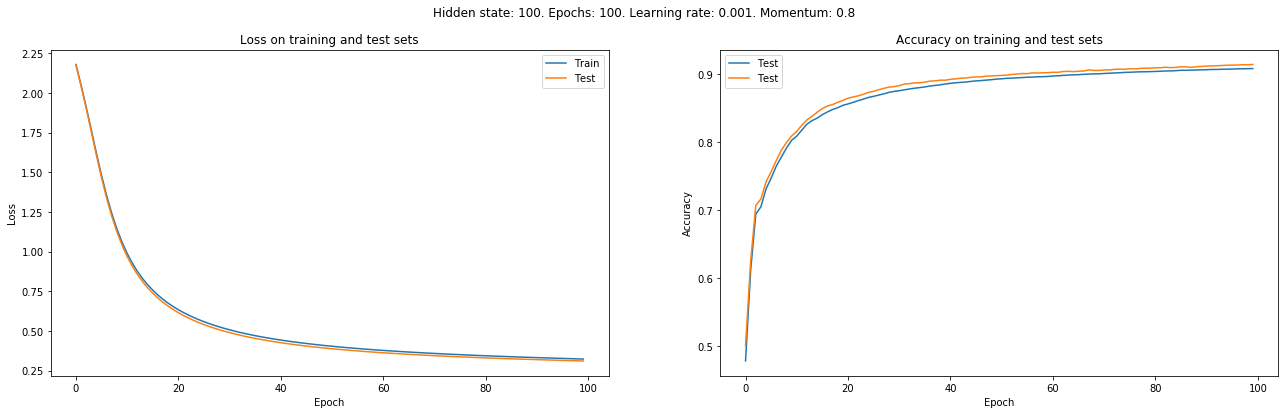

Train accuracy : 0.962. Test accuracy : 0.954


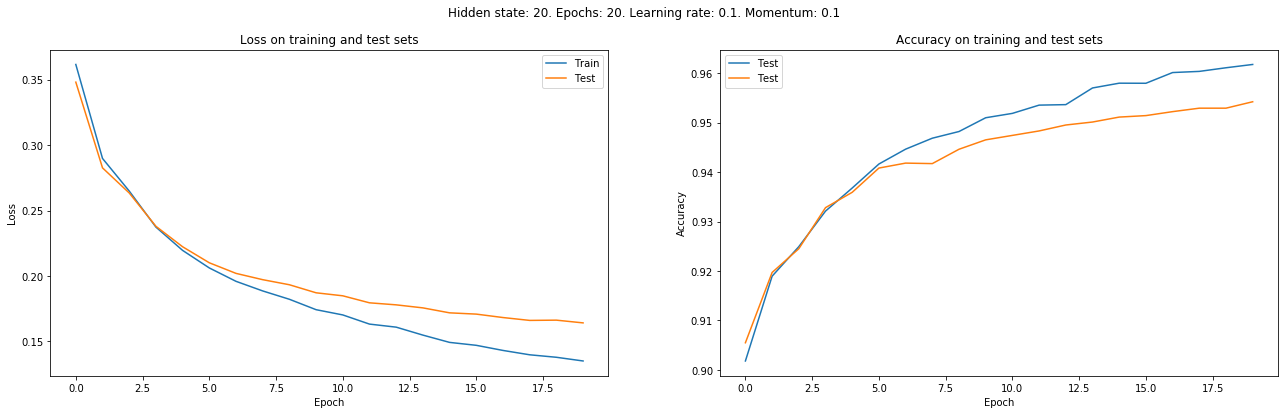

Train accuracy : 0.977. Test accuracy : 0.966


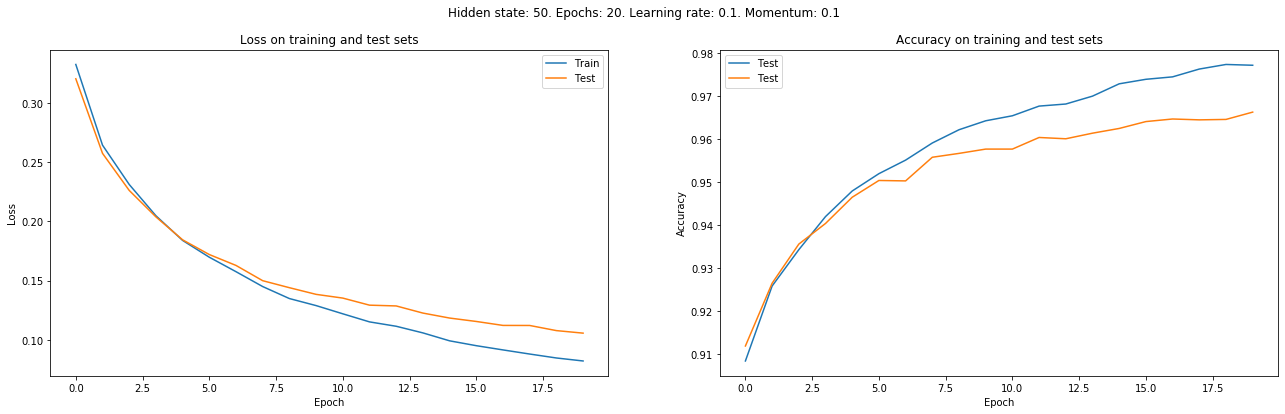

Train accuracy : 0.980. Test accuracy : 0.972


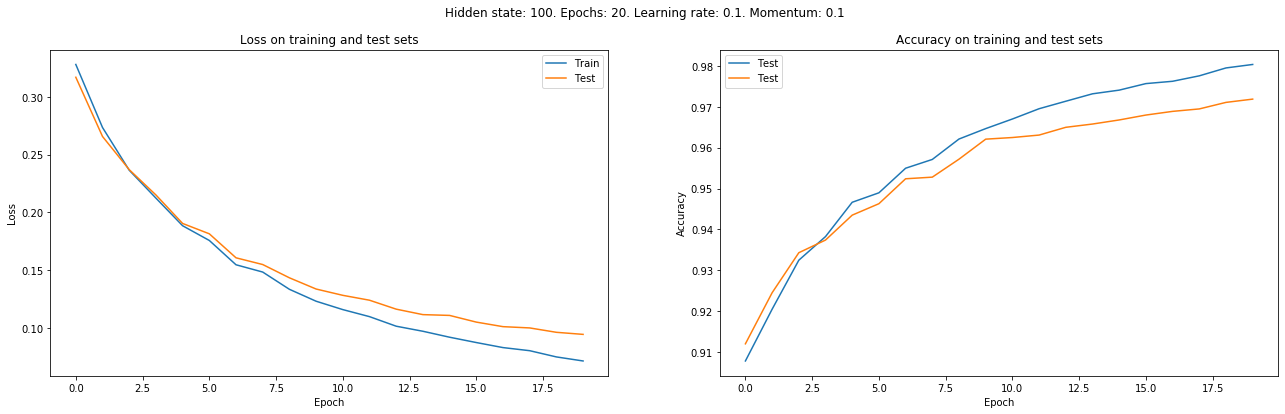

Train accuracy : 0.976. Test accuracy : 0.956


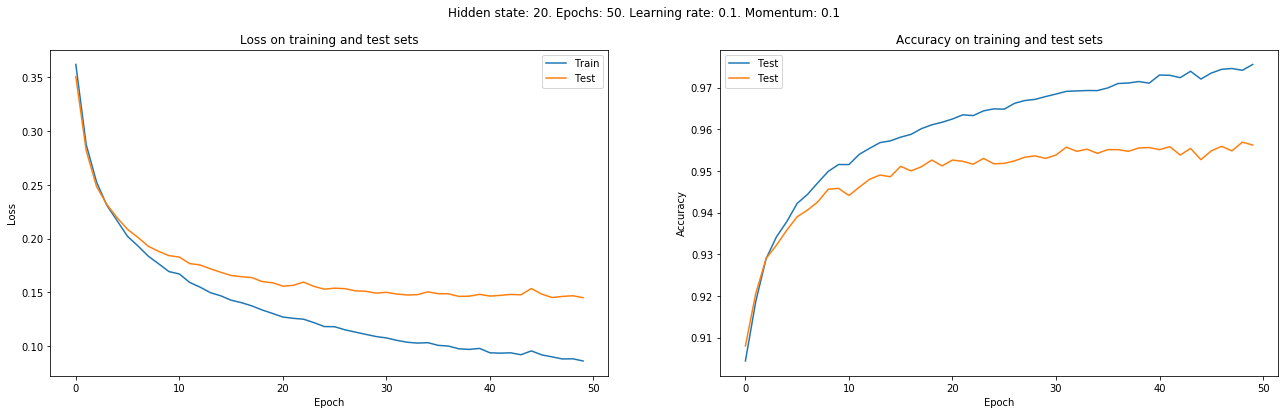

Train accuracy : 0.992. Test accuracy : 0.973


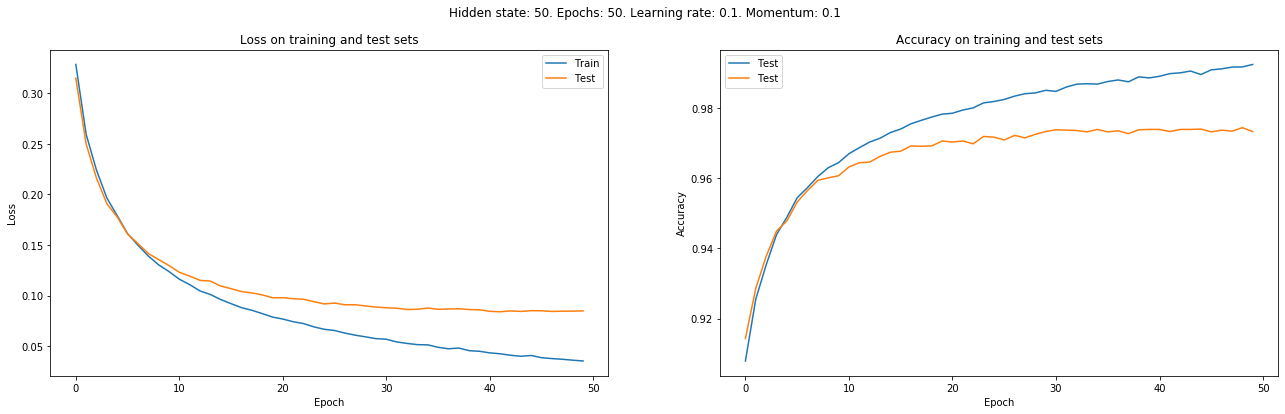

Train accuracy : 0.995. Test accuracy : 0.978


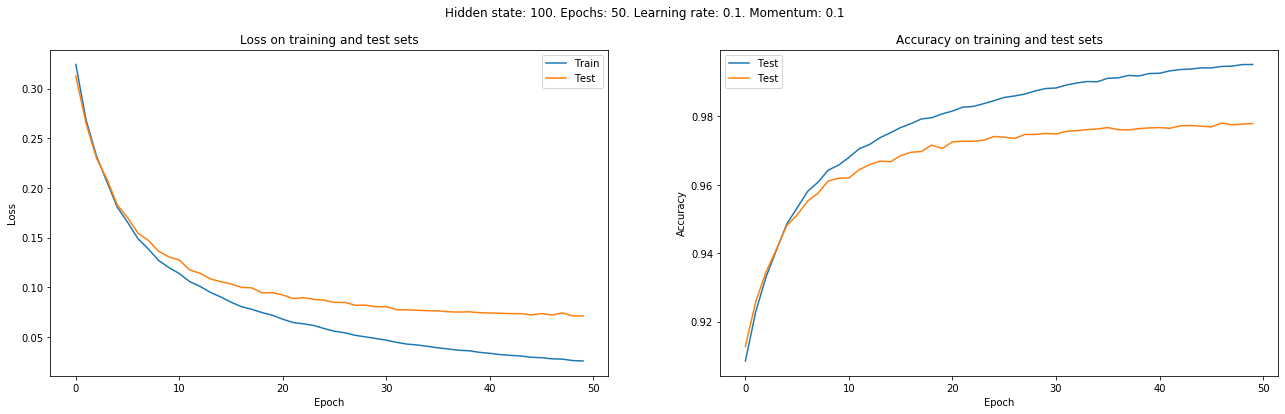

Train accuracy : 0.983. Test accuracy : 0.955


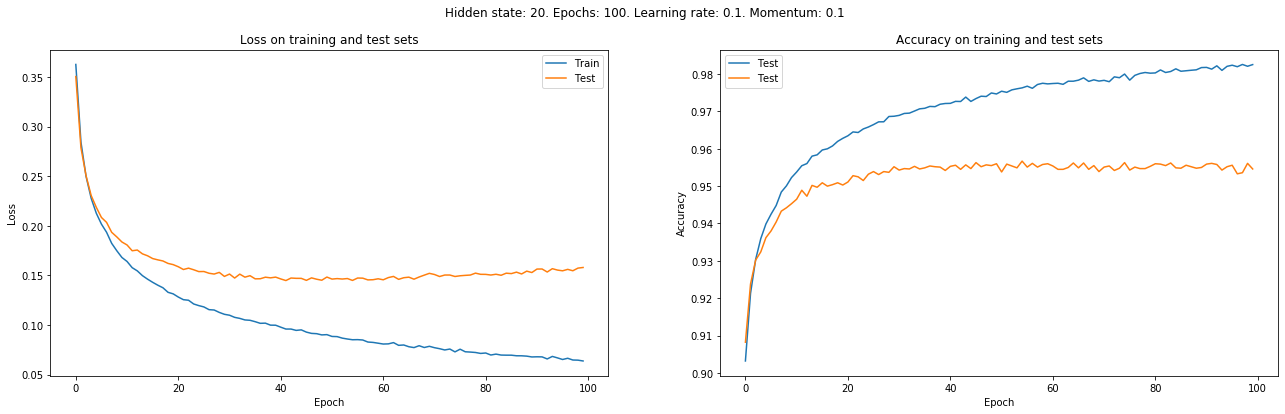

Train accuracy : 0.999. Test accuracy : 0.977


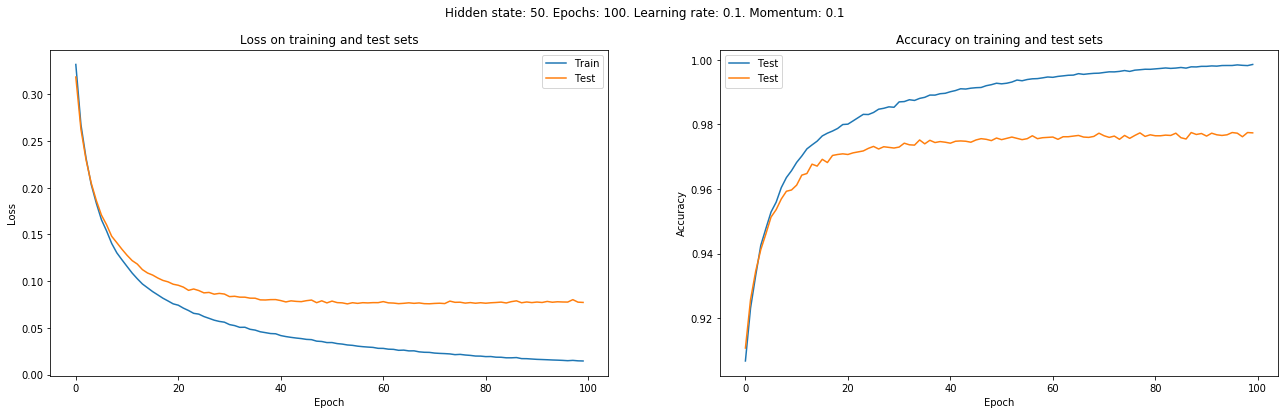

Train accuracy : 1.000. Test accuracy : 0.979


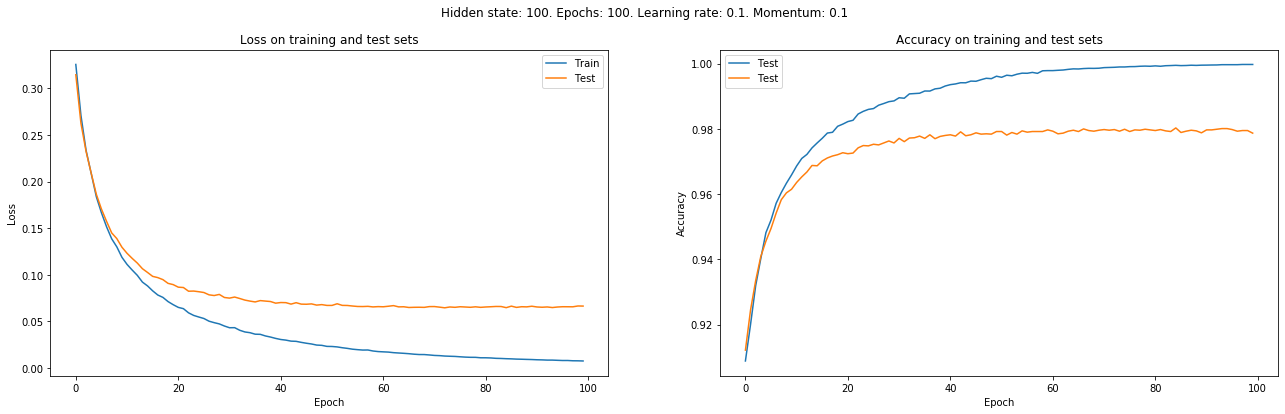

Train accuracy : 0.825. Test accuracy : 0.831


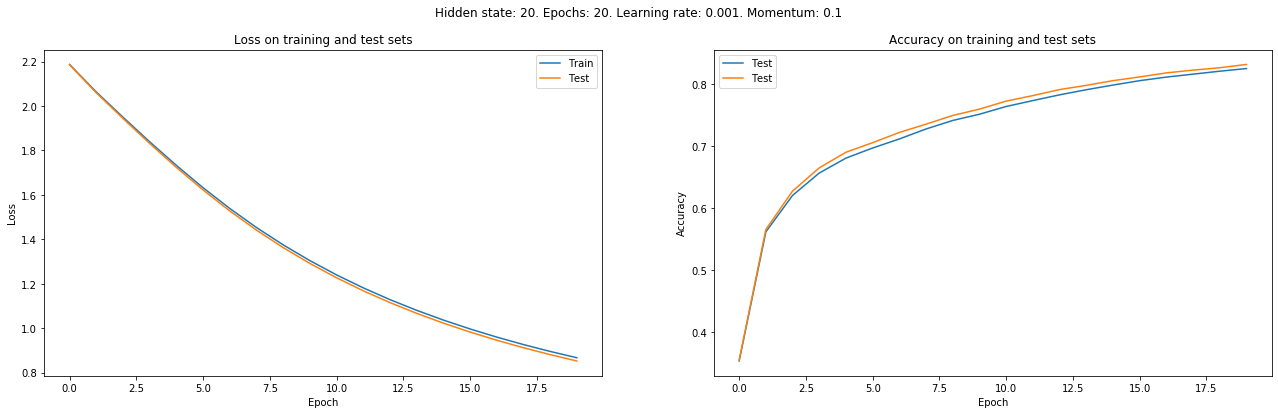

Train accuracy : 0.846. Test accuracy : 0.853


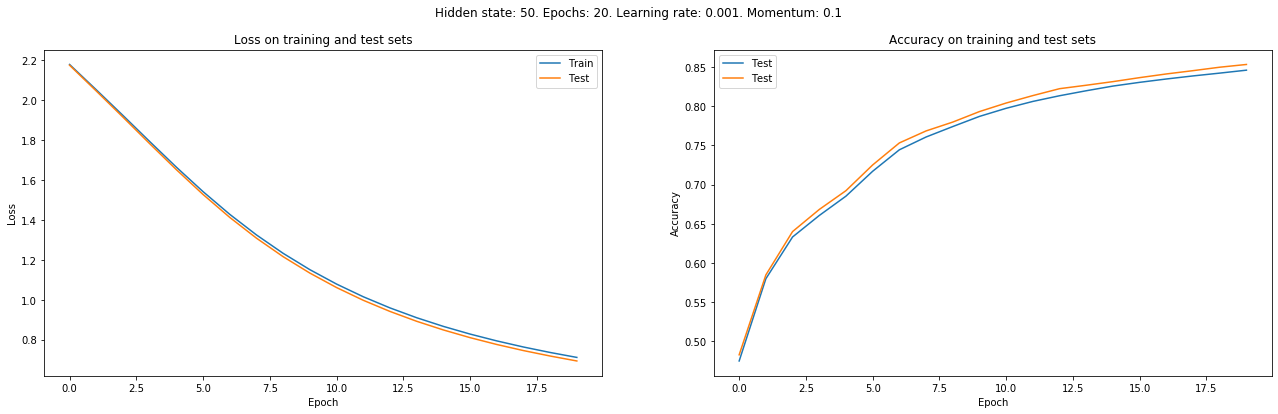

Train accuracy : 0.856. Test accuracy : 0.863


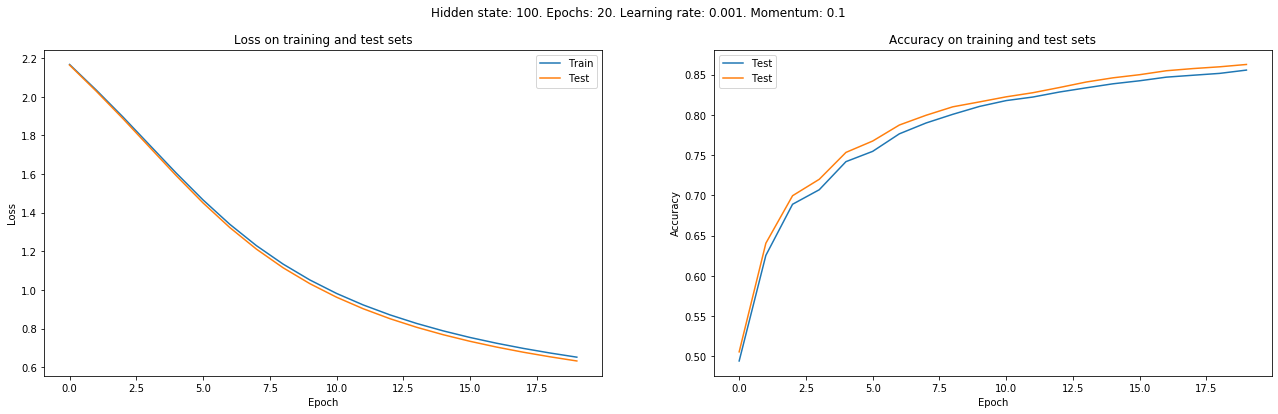

Train accuracy : 0.884. Test accuracy : 0.890


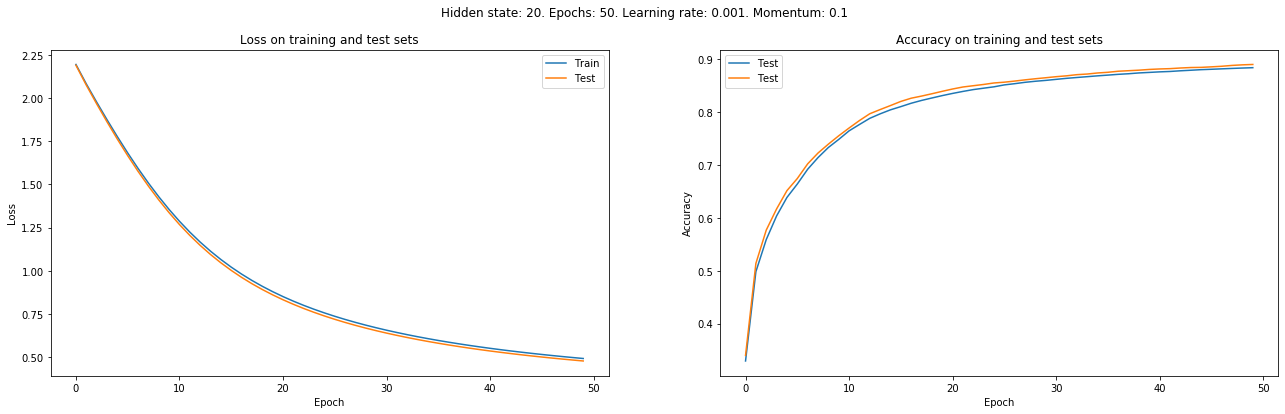

Train accuracy : 0.891. Test accuracy : 0.897


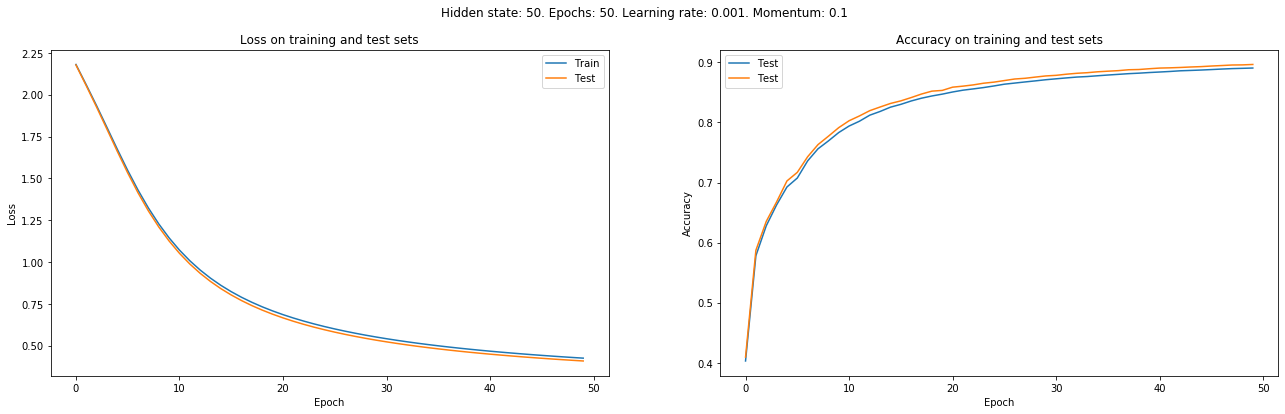

Train accuracy : 0.893. Test accuracy : 0.898


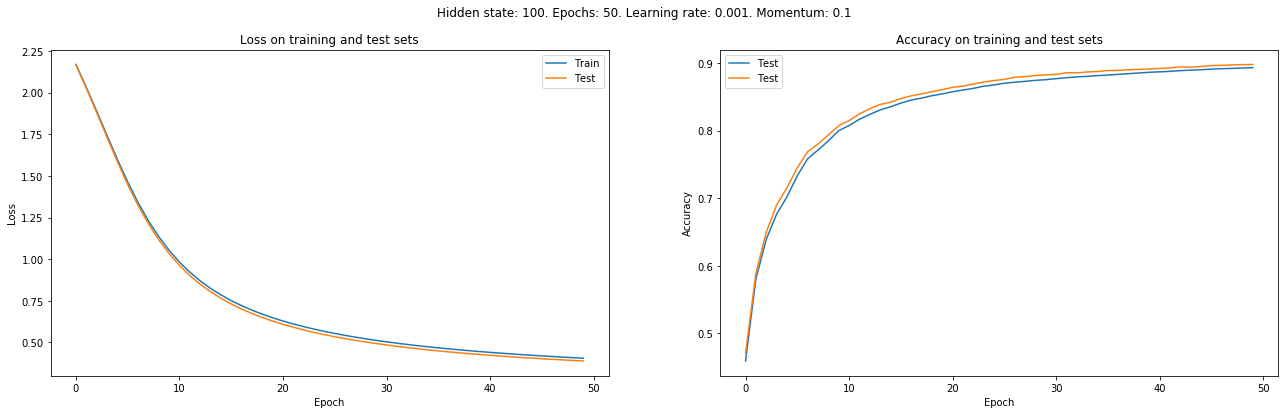

Train accuracy : 0.907. Test accuracy : 0.912


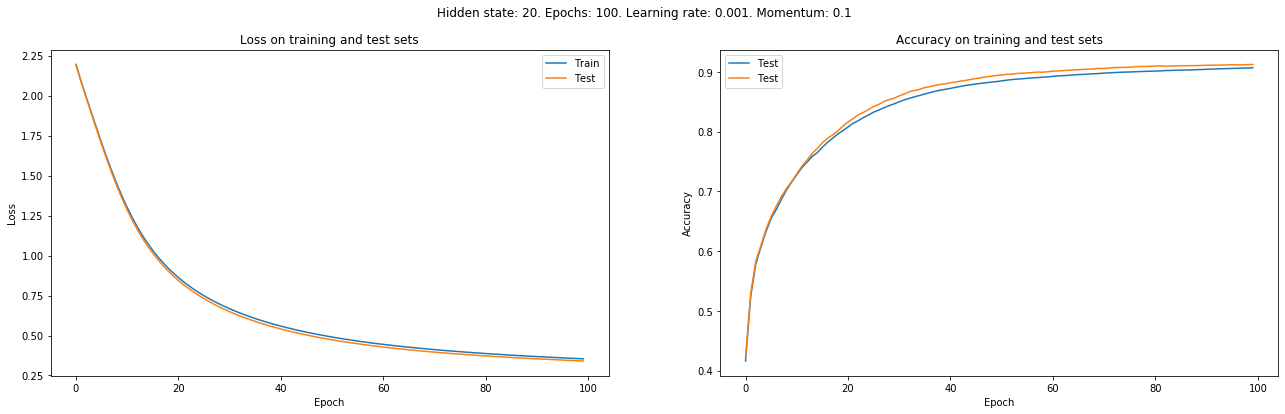

Train accuracy : 0.910. Test accuracy : 0.915


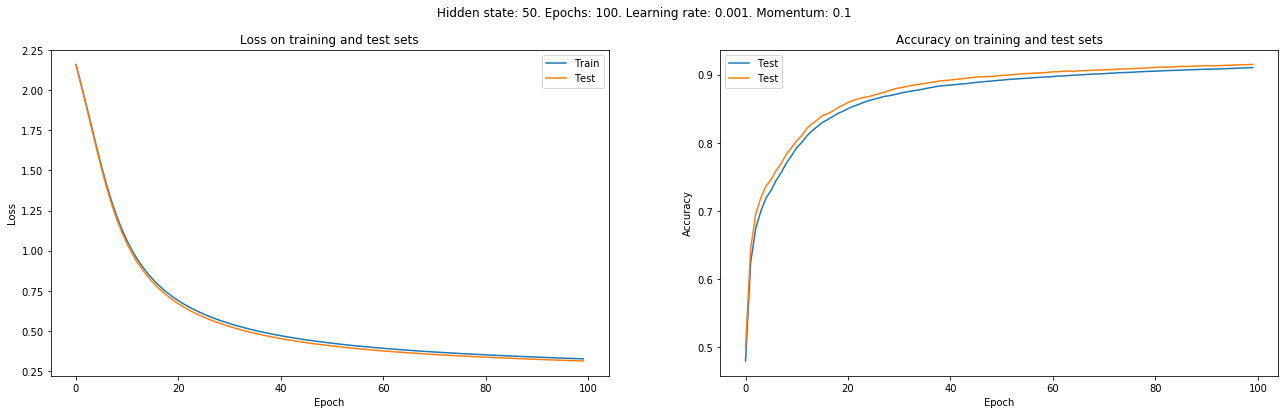

Train accuracy : 0.909. Test accuracy : 0.914


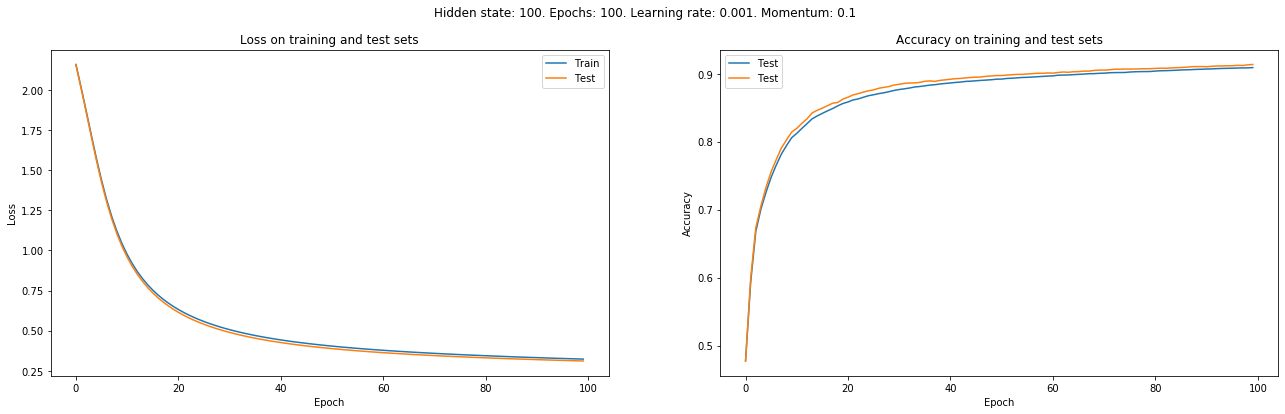

Train accuracy : 0.964. Test accuracy : 0.958


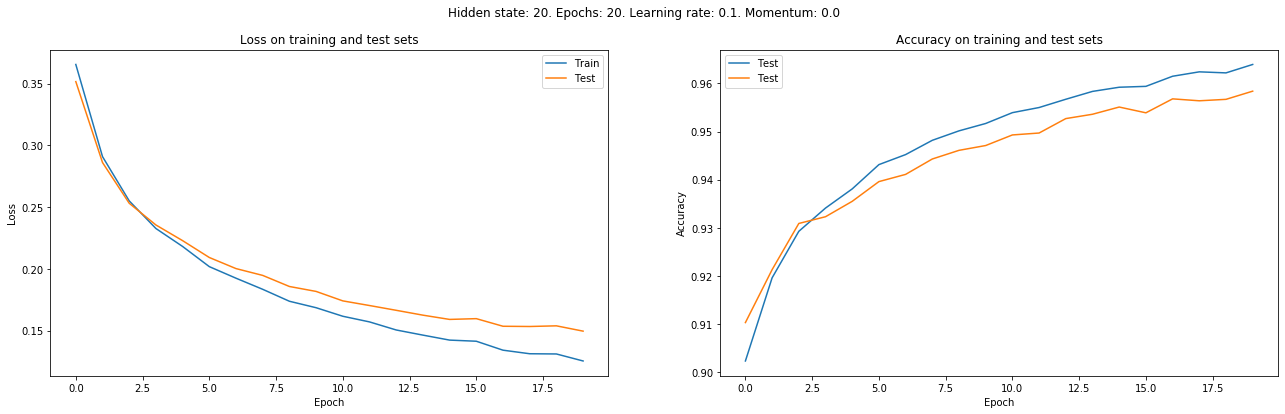

Train accuracy : 0.977. Test accuracy : 0.966


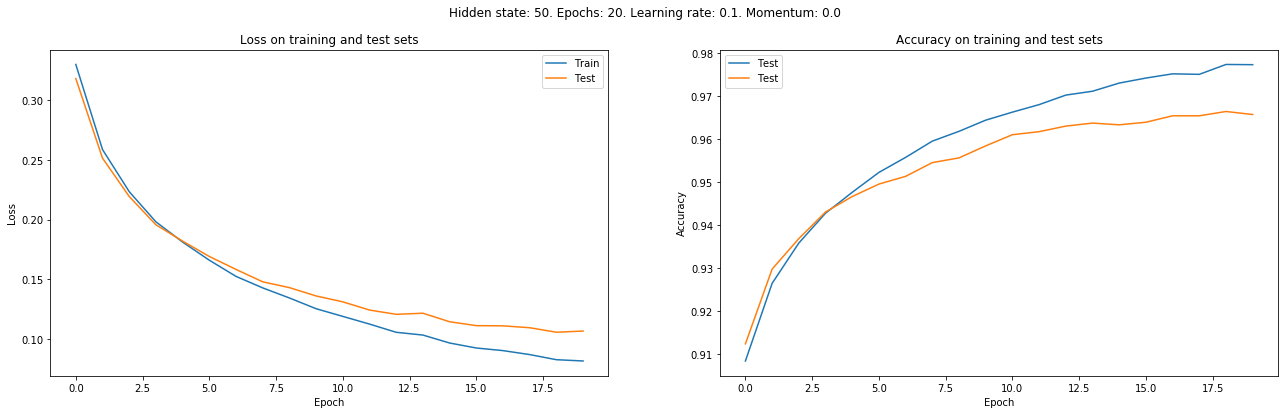

Train accuracy : 0.982. Test accuracy : 0.973


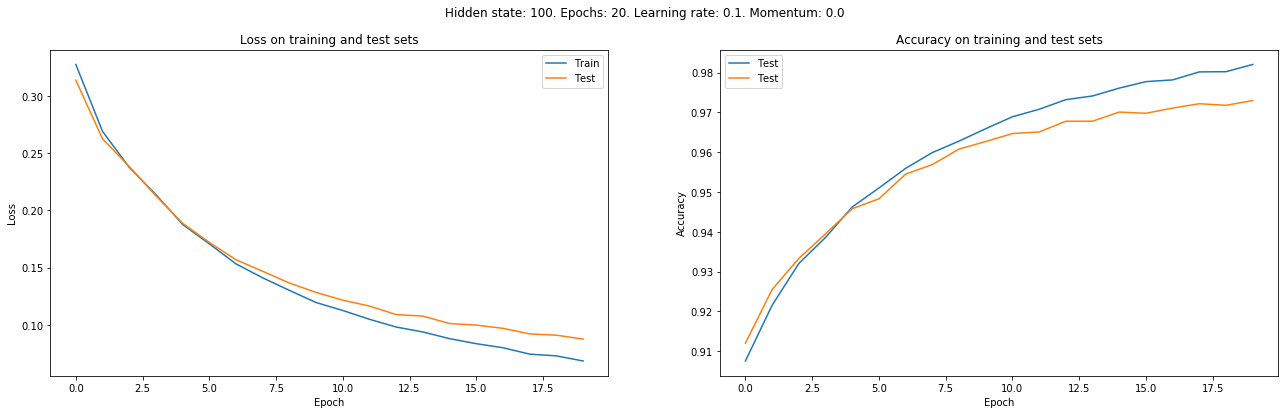

Train accuracy : 0.977. Test accuracy : 0.960


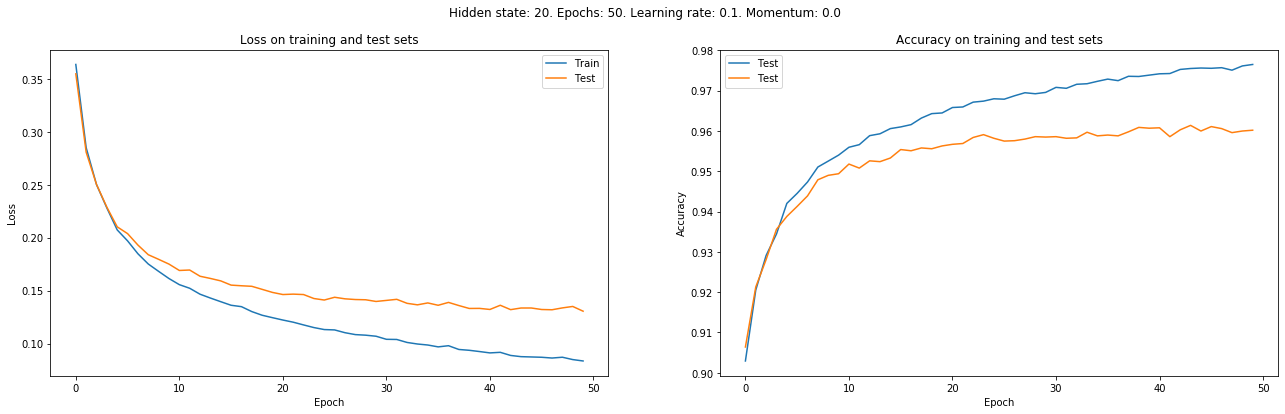

Train accuracy : 0.992. Test accuracy : 0.974


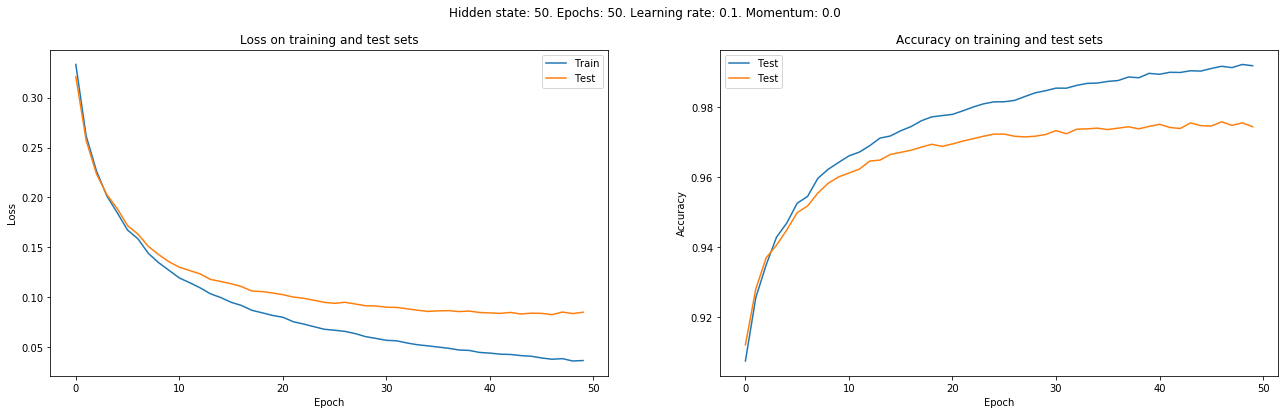

Train accuracy : 0.995. Test accuracy : 0.979


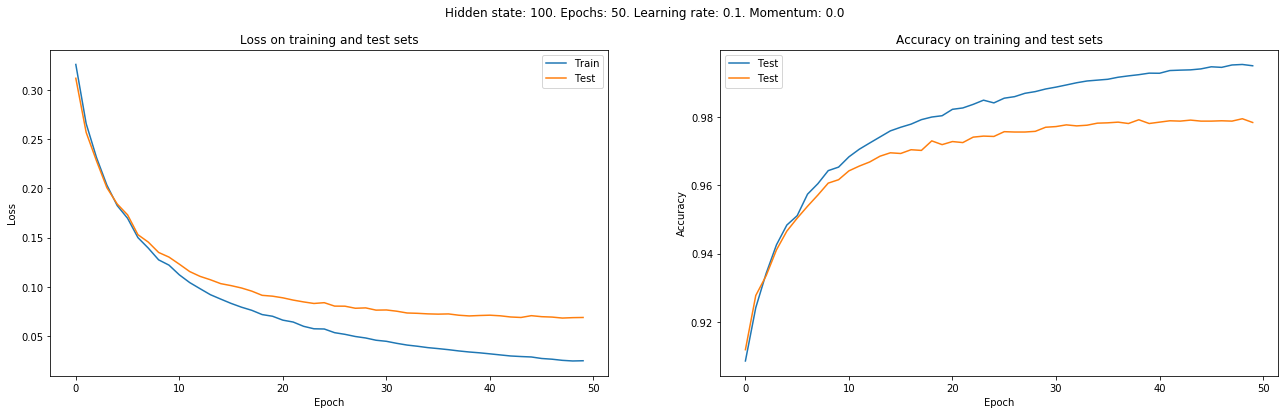

Train accuracy : 0.983. Test accuracy : 0.955


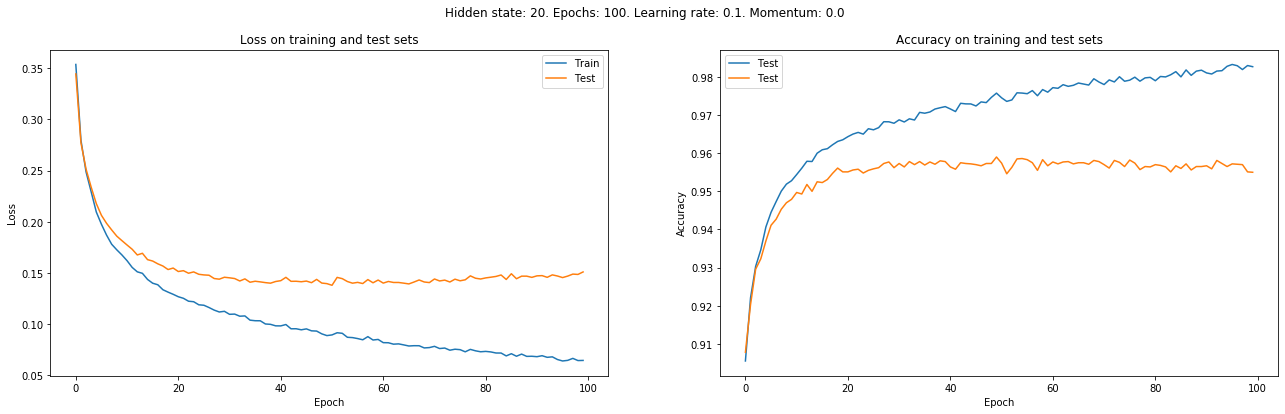

Train accuracy : 0.999. Test accuracy : 0.974


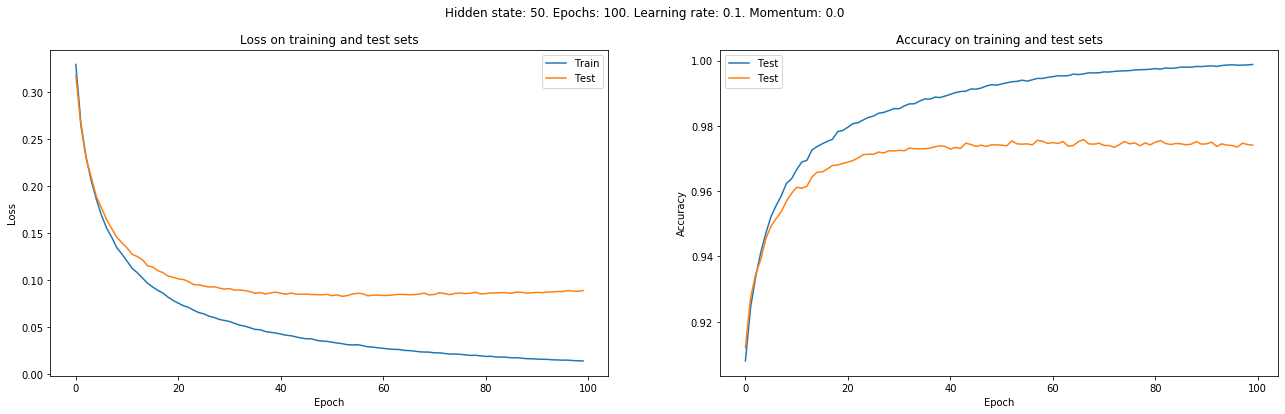

Train accuracy : 1.000. Test accuracy : 0.979


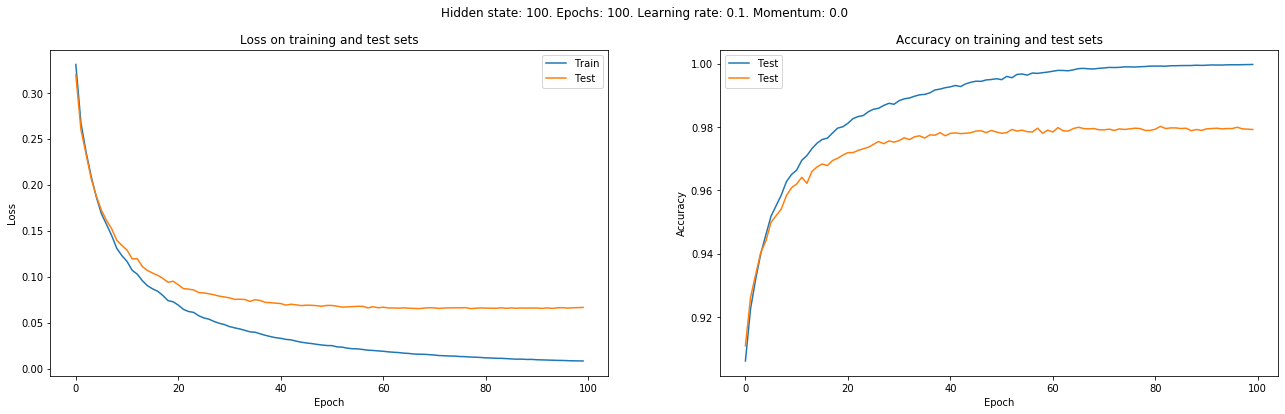

Train accuracy : 0.830. Test accuracy : 0.839


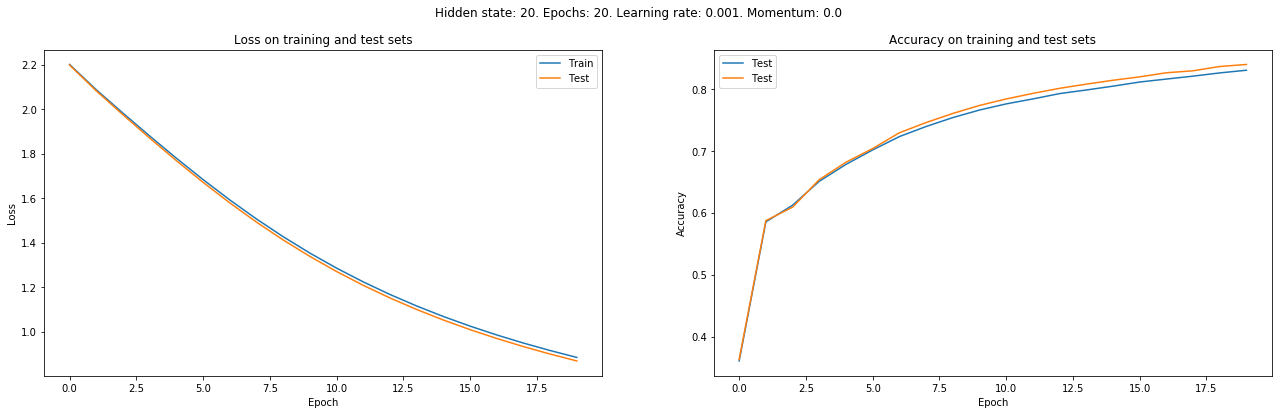

Train accuracy : 0.850. Test accuracy : 0.857


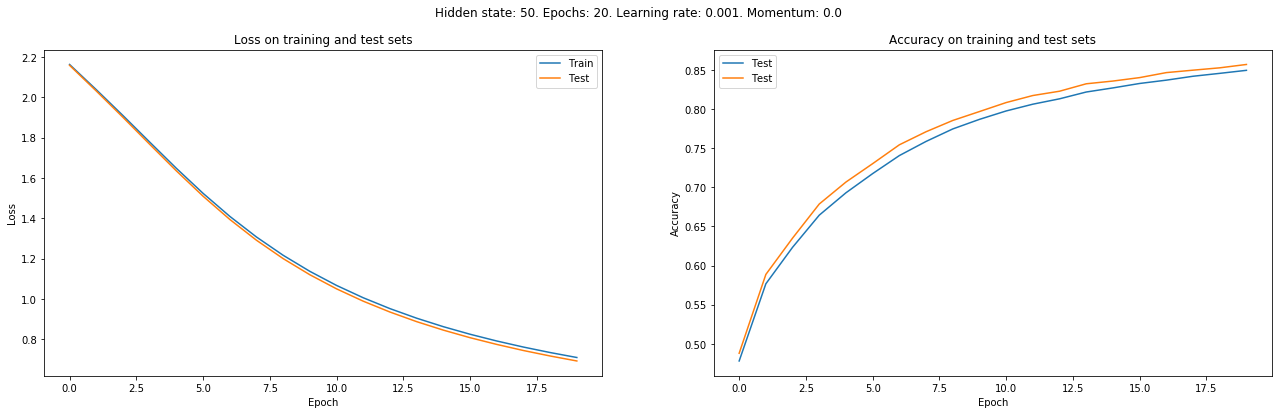

Train accuracy : 0.852. Test accuracy : 0.860


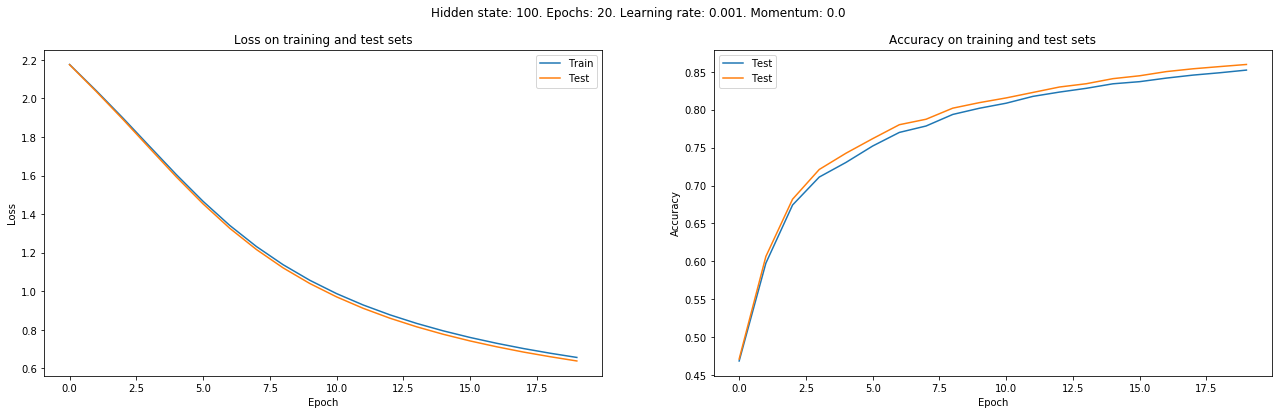

Train accuracy : 0.884. Test accuracy : 0.892


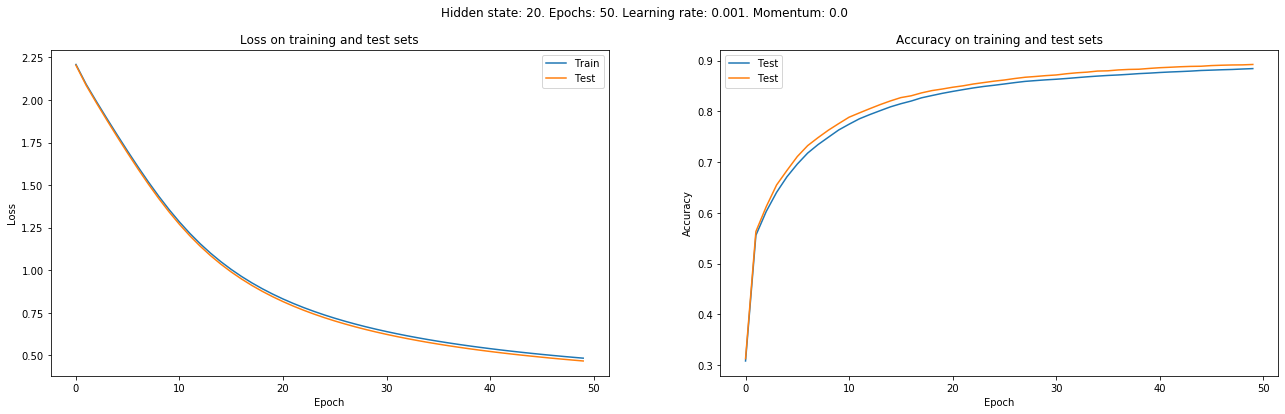

Train accuracy : 0.890. Test accuracy : 0.896


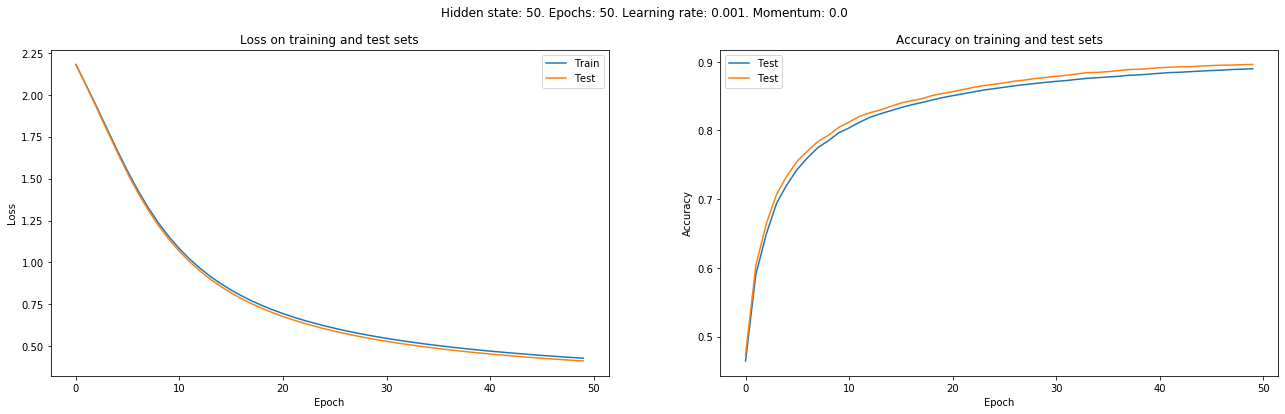

Train accuracy : 0.892. Test accuracy : 0.898


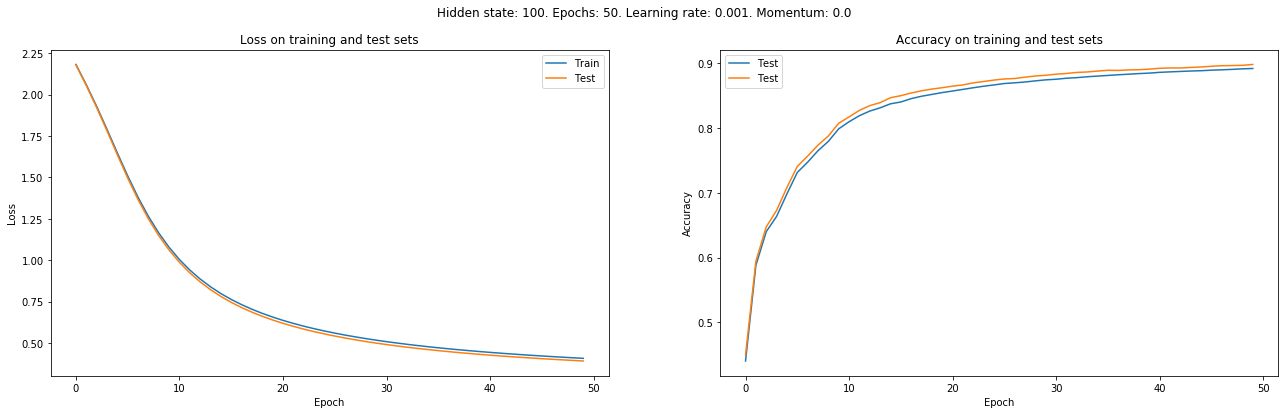

Train accuracy : 0.908. Test accuracy : 0.913


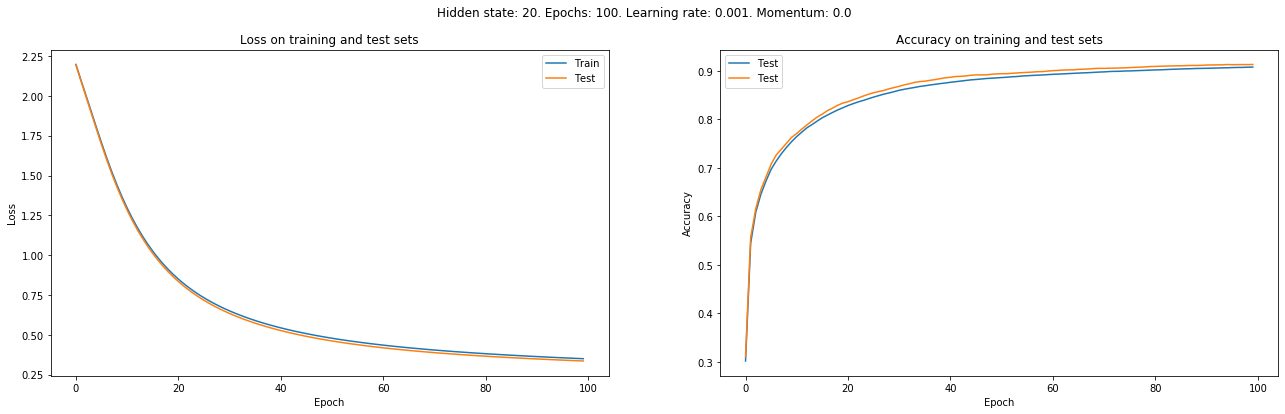

Train accuracy : 0.910. Test accuracy : 0.912


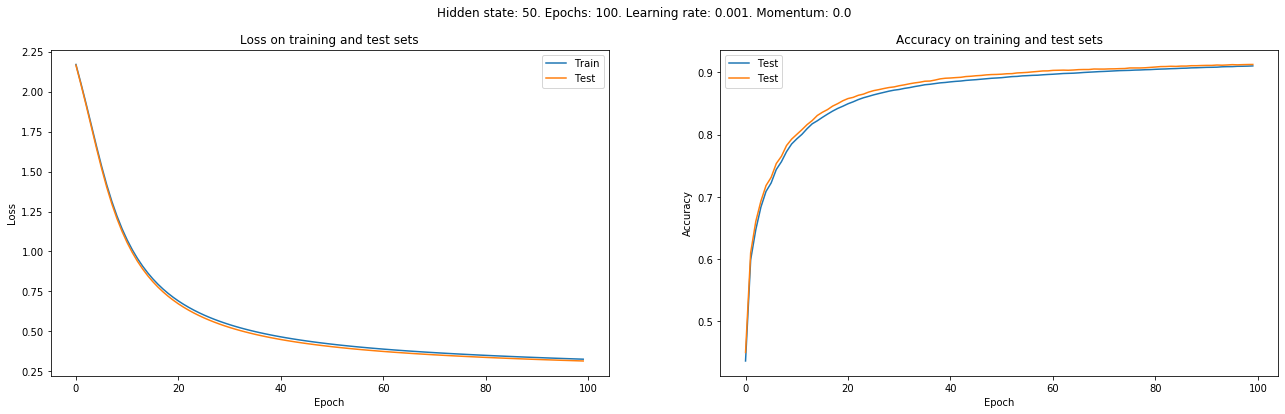

Train accuracy : 0.909. Test accuracy : 0.914


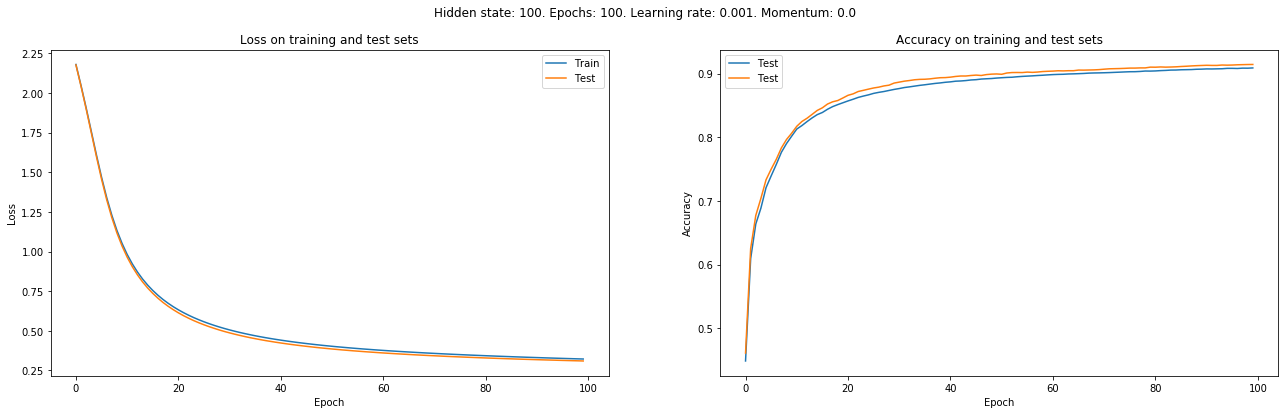

In [0]:
for params in ParameterGrid(params_grid):
    model = simple_NN2(**params)
    model.fit(X_train_full, y_train_full)

### 5-fold cross validation
- Only use the training set instead of including test set during traing phase
- Our class is derived from BaseEstimator so we can use Gridsearch CV for optimal hyperparameters combination

In [0]:
gs = GridSearchCV(simple_NN2(), param_grid = params_grid, cv = 5, verbose=False)
gs.fit(X_train_full, y_train_full)

In [0]:
result = pd.DataFrame(gs.cv_results_)
result.head()

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       1.105997      0.014760  ...        0.006516                8
1       1.964419      0.017744  ...        0.006791                6
2       2.113053      0.028678  ...        0.005923                4
3       3.923450      0.091965  ...        0.004304                2
4       1.106571      0.061073  ...        0.021920               16

[5 rows x 17 columns]